In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import register_module_full_backward_hook
from torch.utils.data import DataLoader, SequentialSampler
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import preprocessing, model_selection, feature_selection
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sn
import json
%matplotlib inline
import random
import mytrain_lib as ml
import importlib

In [2]:
import os
os.getcwd()

'f:\\TFG\\code'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
path_graphs     = 'F:\\TFG\\graphs\\'
path_scores     = 'F:\\TFG\\results\\scores\\'
path_logs       = 'F:\\TFG\\results\\logs\\'
path_outputs    = 'F:\\TFG\\results\\outputs\\'

#### Functions and hooks definitions

In [5]:
from collections import defaultdict

i = 0
def get_activation(name,activation):
    activation[name+'.in'],activation[name+'.out'] = [],[]
    global i; i = 0
    def hook(model, input, output):
        if output.requires_grad==True:
            global i; i+=1
            activation[name+'.in' ].append( input[0].detach().numpy()) # [0] because input is a tuple (idk why)
            activation[name+'.out'].append(output.detach().numpy())
    return hook

def get_gradients(name,gradients):
    gradients[name+'.out'] = []
    def hook(model, grad_in, grad_out):
        if grad_out[0] is not None:
            gradients[name+'.out'].append(grad_out[0].numpy())
    return hook


# Start Simple: implementing bug-free models

- simple data normalizatiom
- simple arquitecture (MLP ~500-1000 params)
- no weight initialization (uniform dist.)
- small batch overfitted
- ADAM optimizer with default configuration
- Cross-Entropy loss
- ReLU as a activation function
- basic dataset (only goals and avg points)

### Training

<a href=https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn>Good practices in DL</a>

<a href=https://stats.stackexchange.com/questions/320383/relationship-between-model-over-fitting-and-number-of-parameters/320387#320387>Relationship between model parameters and overfitting</a>

<a href=https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff>Bias-Variance Decomposition</a>

#### Neural Network definition

In [6]:
class DumbNeuralNetwork(nn.Module):
    def __init__(self, input_feature, ouput_classes, hidden_neurons=[5], cross_entropy=False, 
                        activation=F.relu, activ_opt={'negative_slope':1e-2}):
        torch.manual_seed(0)

        super().__init__()
        self.celoss = cross_entropy
        self.activation = activation
        self.activ_opt = activ_opt
        self.input = nn.Linear(in_features=input_feature, out_features=hidden_neurons[0])
        self.hidden_layers = nn.ModuleList([])
        for i in range(1,len(hidden_neurons)):
            self.hidden_layers.append(nn.Linear(in_features=hidden_neurons[i-1],out_features=hidden_neurons[i]))
        self.out = nn.Linear(hidden_neurons[-1],ouput_classes)

    def forward(self,x):
        if self.activation.__name__=='leaky_relu':
            x = self.input(x)
            for layer in self.hidden_layers:
                x = layer(self.activation(x,**self.activ_opt))
            x = self.activation(x,**self.activ_opt)
            if self.celoss: return self.out(x)
            else:           return F.softmax(self.out(x),1)     
        else:
            x = self.input(x)
            for layer in self.hidden_layers:
                x = layer(self.activation(x))
            x = self.activation(x)
            if self.celoss: return self.out(x)
            else:           return F.softmax(self.out(x),1)   
            
    def reset_weights(self):
        self.input.reset_parameters()
        for layer in self.hidden_layers:
            layer.reset_parameters()
        self.out.reset_parameters()                 


In [7]:
class dumbmodelclass:
    def __init__(self,traindata,hidden_neurons,loss_func,
                    optim=torch.optim.Adam,optim_args={'lr':1e-4},activation=F.relu,
                    activ_opt={'negative_slope':1e-2}):
        torch.manual_seed(0)
        # loss function
        self.loss_func   = loss_func(weight=1-torch.tensor([.25,.46,.29]))
        # model creation
        self.model       = DumbNeuralNetwork(input_feature=traindata.data.shape[1],ouput_classes=3,hidden_neurons=hidden_neurons,
                                cross_entropy=isinstance(self.loss_func,nn.CrossEntropyLoss),
                                activation=activation, activ_opt={'negative_slope':1e-2})
        # register hooks -> relu input and output
        self.activation, self.gradients = {},{}
        self.model.input.register_forward_hook(get_activation('input',self.activation)) # relu input
        self.model.input.register_full_backward_hook(get_gradients('input',self.gradients))
        self.model.out.register_forward_hook(get_activation('output',self.activation)) # relu output
        self.model.out.register_full_backward_hook(get_gradients('output',self.gradients))
        # network weights initialization
        self.weight_dist = np.copy(self.model.state_dict()['input.weight'].numpy().reshape(-1))
        # optimizer
        self.optim       = optim(params=self.model.parameters(),**optim_args)
        # Print out the architecture and number of parameters.
        print(self.model)
        self.params = sum([x.nelement() for x in self.model.parameters()])
        print(f"The model has {self.params} parameters.",end='\n')

        # assign hookers to the layers
        if len(self.model.hidden_layers)>0:
            print('There are hidden layers!')
            for i,h in enumerate(self.model.hidden_layers): 
                h.register_forward_hook(get_activation(f'h{i+1}',self.activation))
                h.register_full_backward_hook(get_gradients(f'h{i+1}',self.gradients))
                print(f'Hook registered h{i+1}')

#### Preprocessing and training

In [8]:
importlib.reload(ml)
# traindata   = ml.FootballMatchesDataset('train','historical_goals',drop=[1,2,3,4,6,7,8,9]) 
# testdata    = ml.FootballMatchesDataset('test','historical_goals',drop=[1,2,3,4,6,7,8,9])
traindata   = ml.WyscoutDataset('train')
testdata    = ml.WyscoutDataset('test')

In [9]:
traindata.data.shape

torch.Size([1100, 20])

In [10]:
# scalling data
traindata.data = (traindata.data - torch.mean(traindata.data,axis=0)) / torch.std(traindata.data,axis=0)
testdata.data  = (testdata.data - torch.mean(testdata.data,axis=0)) / torch.std(testdata.data,axis=0)

In [11]:
torch.manual_seed(0), np.random.seed(0)
batch_size = 8
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=np.random.randint(0,len(traindata.data),batch_size))
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=np.random.randint(0,len(testdata.data),batch_size))

In [15]:
len(trainloader)

1

In [38]:
torch.mean(traindata.data,axis=0), torch.var(traindata.data,axis=0)

(tensor([-5.2019e-08, -1.3872e-08,  1.4652e-07, -7.6727e-08, -3.1471e-07,
          4.8984e-08, -5.9821e-08, -1.3005e-08, -3.9014e-08, -6.9358e-08,
         -7.4127e-08,  1.5779e-07, -4.8648e-07,  1.0386e-06,  3.7280e-08,
         -5.9821e-08,  4.8551e-08, -8.6698e-10, -7.9762e-08,  1.2311e-07]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000]))

In [11]:
data = pd.DataFrame(traindata.data.tolist())
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1100.000000,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03
mean,-5.845192e-08,-1.876880e-08,1.452897e-07,-7.599592e-08,-3.184628e-07,5.080449e-08,-3.858046e-08,-1.502308e-08,-4.389916e-08,-7.921533e-08,-7.689739e-08,1.548495e-07,-4.889996e-07,0.000001,4.233962e-08,-5.921857e-08,5.323313e-08,-2.472238e-10,-8.728863e-08,1.287189e-07
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.864877e+00,-1.859680e+00,-2.413583e+00,-2.327798e+00,-3.549780e+00,-3.329182e+00,-1.524289e+00,-1.309201e+00,-2.271601e+00,-1.883159e+00,-2.604927e+00,-2.109739e+00,-3.789687e+00,-2.959246,-1.822299e+00,-1.710033e+00,-1.769300e+00,-1.763309e+00,-1.586053e+00,-1.876863e+00
25%,-1.094151e-01,-1.111953e-01,-7.430896e-01,-7.224873e-01,-6.324475e-01,-6.683599e-01,-6.903085e-01,-8.278773e-01,-6.387085e-01,-6.525469e-01,-6.689758e-01,-6.781944e-01,-6.815894e-01,-0.704343,-7.674225e-01,-7.420898e-01,-7.426349e-01,-6.804172e-01,-7.205400e-01,-7.113565e-01
50%,3.767409e-01,3.675450e-01,-1.276447e-01,-8.036291e-02,-3.015962e-02,-1.179312e-02,-2.733182e-01,-3.465533e-01,1.444847e-02,5.066024e-02,-1.491945e-01,-1.695787e-01,4.954547e-02,0.007988,-2.399843e-01,-9.679437e-02,-1.826360e-01,-1.389711e-01,-1.254995e-01,-1.286029e-01
75%,6.467768e-01,6.694620e-01,4.878002e-01,6.687822e-01,6.466907e-01,6.848584e-01,5.606624e-01,6.160947e-01,6.917964e-01,6.549788e-01,5.479970e-01,5.291881e-01,7.357088e-01,0.738422,5.511730e-01,5.485010e-01,5.640293e-01,6.431177e-01,5.777301e-01,5.998389e-01
max,1.384692e+00,1.467990e+00,3.916707e+00,3.451321e+00,2.919088e+00,3.969074e+00,4.313575e+00,5.429335e+00,1.538481e+00,1.501025e+00,4.625323e+00,5.177843e+00,2.557356e+00,2.323986,4.243240e+00,5.388217e+00,4.624022e+00,3.771473e+00,4.851202e+00,4.436299e+00


In [13]:
importlib.reload(ml)

<module 'mytrain_lib' from 'f:\\TFG\\code\\mytrain_lib.py'>

##### Model and parameters definition

In [14]:
model = dumbmodelclass(traindata,[15,10],nn.CrossEntropyLoss)

DumbNeuralNetwork(
  (input): Linear(in_features=20, out_features=15, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=15, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=3, bias=True)
)
The model has 508 parameters.
There are hidden layers!
Hook registered h1


In [29]:
title=f'wyscout_overfitting_batch{batch_size}_{model.params}params'
run_path = 'overfitting_batch_wyscout\\'

In [16]:
i

0

In [221]:
torch.manual_seed(0)
# model = dumbmodelclass(traindata,[5],nn.CrossEntropyLoss)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,3000)
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title='_'+title)
ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title='_'+title)

# ANALYSIS

#### Error & accuracy

In [92]:
# with open(path_logs+title+'.json') as json_file:
#     data = json.load(json_file)

# trainlogs = pd.DataFrame(data['train'])
# testlogs  = pd.DataFrame(data['test'])

In [177]:
# title = 'nndo_4layers_10163params_dropout0.25'
logs = pd.read_csv(path_logs+title+'_logs.csv',sep=';')
with open(path_logs+title+'_wg.json') as wg:
    weights_grads = json.load(wg)

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\TFG\\results\\logs\\nnbn_pca_4layers_9113params_pca10_wg.json'

In [176]:
run_path = 'm3_wyscout\\'
path_logs+title+'_logs.csv'

'F:\\TFG\\results\\logs\\nnbn_pca_4layers_9113params_pca10_logs.csv'

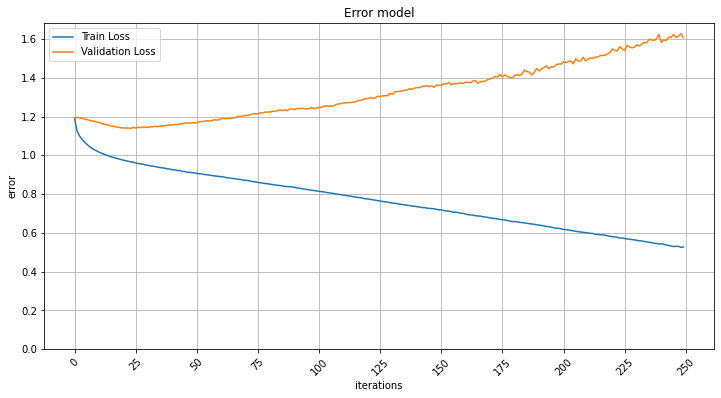

In [178]:
ml.plot_error([logs.trainloss,logs.testloss],path_exec=path_graphs,title=run_path+'error_'+title)

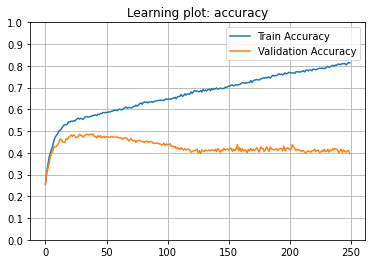

In [179]:
importlib.reload(ml)
ml.plot_accuracy([logs.acc_train,logs.acc_test],path_exec=path_graphs,title=run_path+'accuracy_'+title)

#### Weights evolution and distribution

<class 'matplotlib.axes._subplots.AxesSubplot'>


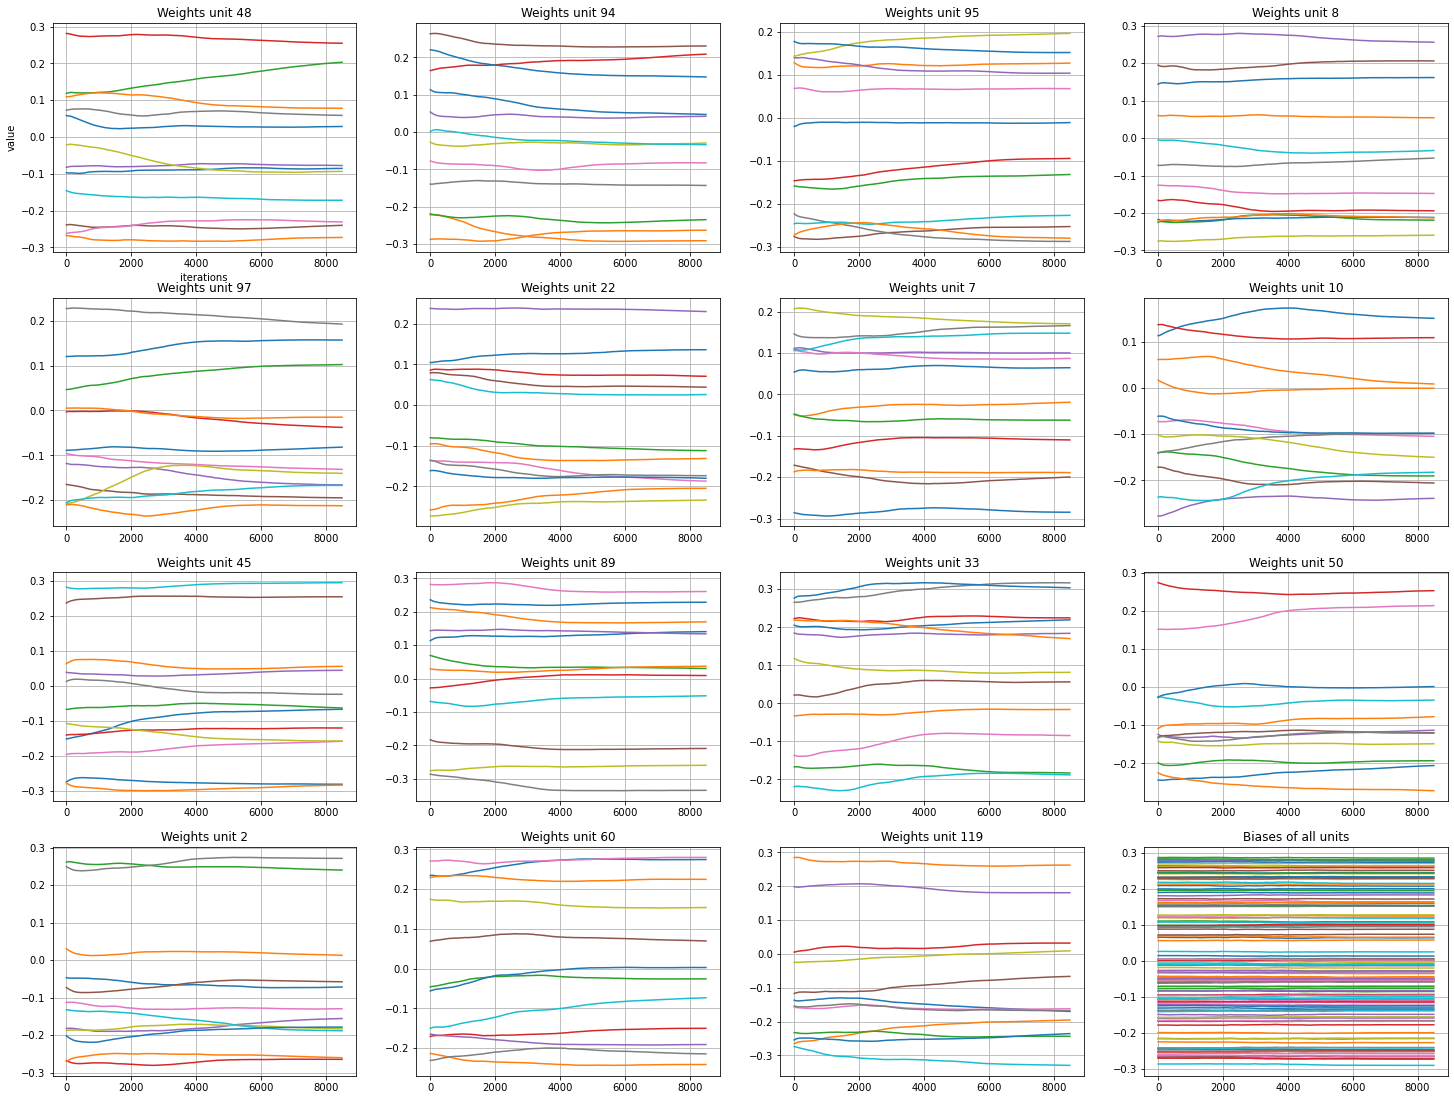

In [104]:
importlib.reload(ml)
ml.plot_weights(weights_grads['weights'],path_graphs,traindata.features,title=run_path+'weights_input_'+title,ncols=4, 
                rand_units=15,leg_flag=0)

<class 'matplotlib.axes._subplots.AxesSubplot'>


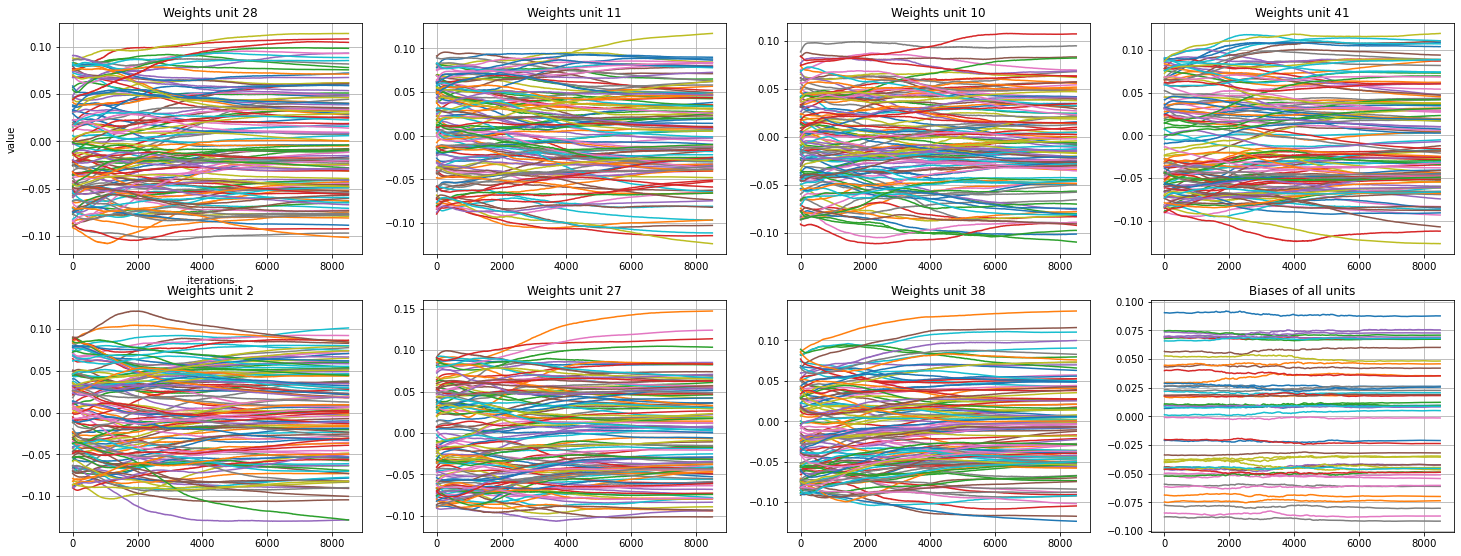

In [105]:
importlib.reload(ml)
ml.plot_weights(weights_grads['weights'],path_graphs,traindata.features,layer='hidden_layers.0',
                    title=run_path+'weights_hidden0_'+title,ncols=4,rand_units=7,leg_flag=False)

<class 'matplotlib.axes._subplots.AxesSubplot'>


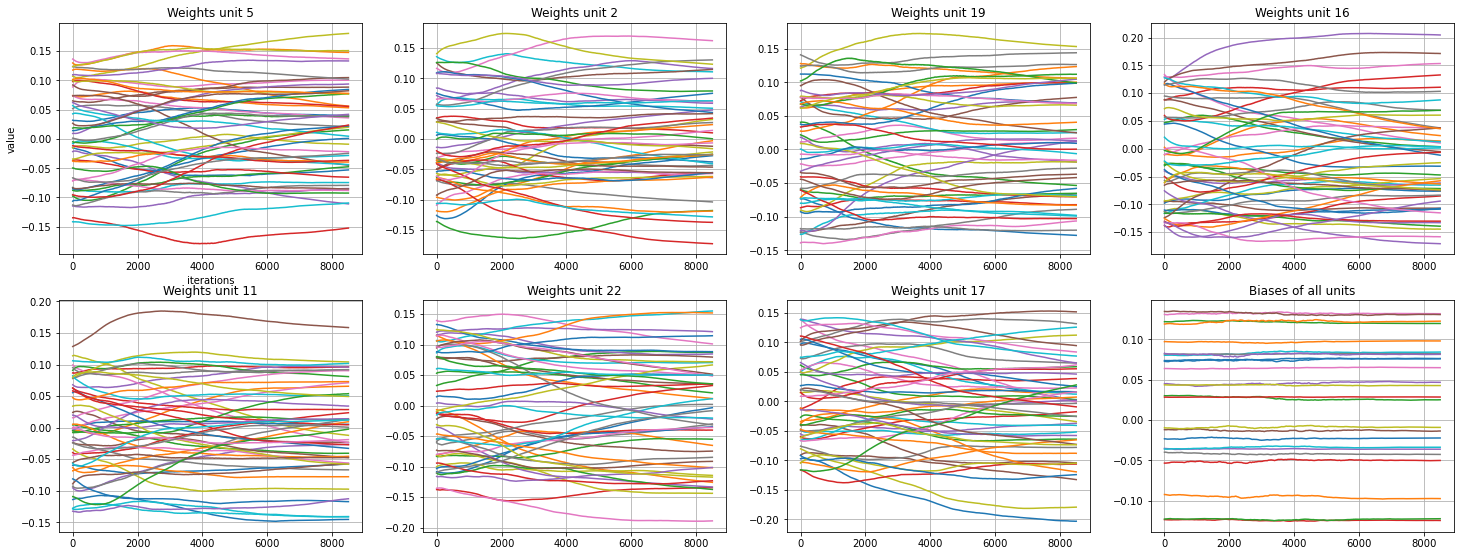

In [106]:
importlib.reload(ml)
ml.plot_weights(weights_grads['weights'],path_graphs,traindata.features,layer='hidden_layers.1',
                    title=run_path+'weights_hidden1_'+title,ncols=4,rand_units=7,leg_flag=False)

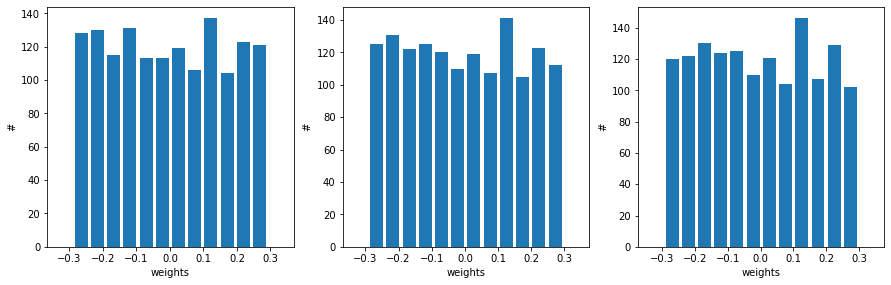

In [107]:
importlib.reload(ml)
data_plot = [model.weight_dist,
            np.array(weights_grads['weights'][124].get('input.weight')).reshape(-1),
            np.array(weights_grads['weights'][249].get('input.weight')).reshape(-1)
            ]
ml.plot_weight_dist(data_plot,path_graphs,title=run_path+'weight_dist_input_'+title)

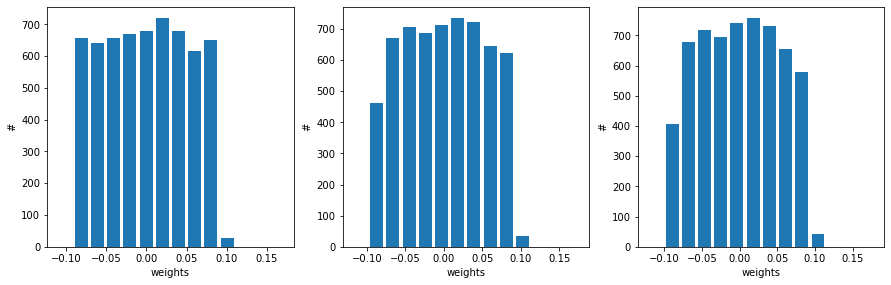

In [108]:
layer = 'hidden_layers.0'
data_plot = [np.array(weights_grads['weights'][0].get(layer+'.weight')).reshape(-1),
            np.array(weights_grads['weights'][124].get(layer+'.weight')).reshape(-1),
            np.array(weights_grads['weights'][249].get(layer+'.weight')).reshape(-1)
            ]
ml.plot_weight_dist(data_plot,path_graphs,title=run_path+'weight_dist_'+layer+'_'+title)


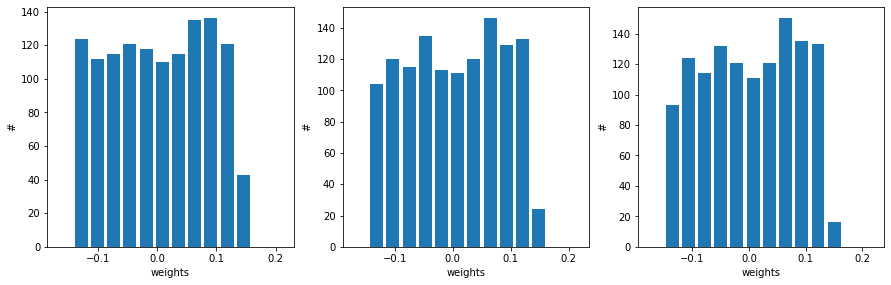

In [109]:
layer = 'hidden_layers.1'
data_plot = [np.array(weights_grads['weights'][0].get(layer+'.weight')).reshape(-1),
            np.array(weights_grads['weights'][124].get(layer+'.weight')).reshape(-1),
            np.array(weights_grads['weights'][249].get(layer+'.weight')).reshape(-1)
            ]
ml.plot_weight_dist(data_plot,path_graphs,title=run_path+'weight_dist_'+layer+'_'+title)

#### Gradients

Understanding of `grad_input` and `grad_output`: https://discuss.pytorch.org/t/exact-meaning-of-grad-input-and-grad-output/14186/5

In [180]:
input_out   = np.array(model.gradients['input.out'])
h1_out      = np.array(model.gradients['h1.out'])
output_out  = np.array(model.gradients['output.out'])
h2_out      = np.array(model.gradients['h2.out'])

In [181]:
output_out.shape

(8500, 32, 3)

In [17]:
import sklearn.preprocessing as preprocessing
preprocessing.normalize([
    [1,0,0],
    [0,0,3],
    [0,2,0],
    [0,1,0],
    [0,0,7],
    [0,0,1],
    [1,0,0],
    [0,2,0],
    [0,0,2],
    [0,2,0],
    [0,1,0],
    [0,2,0],
    [0,1,0],
    [0,2,0],
    [0,1,0],
    [0,2,0],
    [0,1,0],
    [0,0,1],
    [0,0,1],
    [1,0,0],
    [1,0,0],
    [1,0,0],
    [0,2,0],
    [0,1,0],
    [0,0,1],
    [0,0,1],
    [1,0,0],
    [0,5,0],
    [1,0,0],
    [0,2,0],
    [0,1,0],
    [0,0,2],
    [0,0,1],
    [1,0,0],
    [0,5,0],
    [1,0,0],
    [0,2,0],
    [0,6,0],
    [0,0,4],
    [0,0,1],
    [1,0,0],
    [1,0,0],
    [0,0,3],
    [0,2,0],
    [0,1,0],
    [0,0,7],
    [0,0,1],
    [1,0,0],
    [0,2,0],
    [0,0,2],
    [0,2,0],
    [0,1,0],
    [0,2,0],
    [0,1,0],
    [0,2,0],
    [0,1,0],
    [0,2,0],
    [0,1,0],
    [0,0,1],
    [0,0,1],
    [1,0,0],
    [1,0,0],
    [1,0,0],
    [0,2,0],
    [0,1,0],
    [0,0,1],
    [0,0,1],
    [1,0,0],
    [0,5,0],
    [1,0,0],
    [0,2,0],
    [0,1,0],
    [0,0,2],
    [0,0,1],
    [1,0,0],
    [0,5,0],
    [1,0,0],
    [0,2,0],
    [0,6,0],
    [0,0,4],
    [0,0,1],
    [1,0,0],
    [1,0,0],
    [0,0,3],
    [0,2,0],
    [0,1,0],
    [0,0,7],
    [0,0,1],
    [1,0,0],
    [0,2,0],
    [0,0,2],
    [0,2,0],
    [0,1,0],
    [0,2,0],
    [0,1,0],
    [0,2,0],
    [0,1,0],
    [0,2,0],
    [0,1,0],
    [0,0,1],
    [0,0,1],
    [1,0,0],
    [1,0,0],
    [1,0,0],
    [0,2,0],
    [0,1,0],
    [0,0,1],
    [0,0,1],
    [1,0,0],
    [0,5,0],
    [1,0,0],
    [0,2,0],
    [0,1,0],
    [0,0,2],
    [0,0,1],
    [1,0,0],
    [0,5,0],
    [1,0,0],
    [0,2,0],
    [0,6,0],
    [0,0,4],
    [0,0,1],
    [1,0,0],
],axis=0)

array([[0.18257419, 0.        , 0.        ],
       [0.        , 0.        , 0.18359702],
       [0.        , 0.10166571, 0.        ],
       [0.        , 0.05083286, 0.        ],
       [0.        , 0.        , 0.42839304],
       [0.        , 0.        , 0.06119901],
       [0.18257419, 0.        , 0.        ],
       [0.        , 0.10166571, 0.        ],
       [0.        , 0.        , 0.12239801],
       [0.        , 0.10166571, 0.        ],
       [0.        , 0.05083286, 0.        ],
       [0.        , 0.10166571, 0.        ],
       [0.        , 0.05083286, 0.        ],
       [0.        , 0.10166571, 0.        ],
       [0.        , 0.05083286, 0.        ],
       [0.        , 0.10166571, 0.        ],
       [0.        , 0.05083286, 0.        ],
       [0.        , 0.        , 0.06119901],
       [0.        , 0.        , 0.06119901],
       [0.18257419, 0.        , 0.        ],
       [0.18257419, 0.        , 0.        ],
       [0.18257419, 0.        , 0.        ],
       [0.

In [182]:
input_out   = np.abs(input_out.reshape(input_out.shape[0],-1))
h1_out      = np.abs(h1_out.reshape(h1_out.shape[0],-1))
output_out  = np.abs(output_out.reshape(output_out.shape[0],-1))
h2_out      = np.abs(h2_out.reshape(h2_out.shape[0],-1))

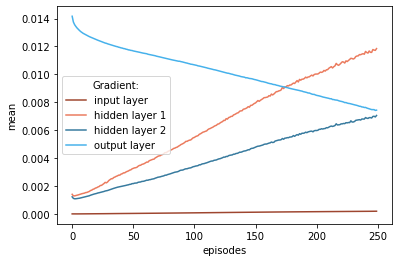

In [183]:
# we have to make the mean out of the whole train set and activation neurons
plt.plot(np.mean(input_out.reshape(int(len(input_out)/34),-1),axis=1),label='input layer',color='#9E462F')
plt.plot(np.mean(h1_out.reshape(int(len(h1_out)/34),-1),axis=1),label='hidden layer 1',color='#EB7B5E')
plt.plot(np.mean(h2_out.reshape(int(len(h2_out)/34),-1),axis=1),label='hidden layer 2',color='#377A9E')
plt.plot(np.mean(output_out.reshape(int(len(output_out)/34),-1),axis=1),label='output layer',color='#46B1EB')
plt.legend(title='Gradient:')
# plt.xticks(ticks=np.linspace(0,100,5),labels=np.linspace(0,250,5).astype(int))
plt.ylabel('mean')
plt.xlabel('episodes')
plt.savefig(path_graphs +run_path+ 'grads_mean_' +title + '.jpg', format='jpg', dpi=200, bbox_inches='tight')
plt.show()

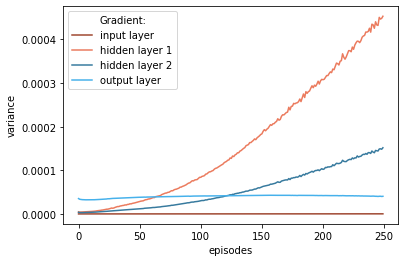

In [184]:
# we have to make the mean out of the whole train set and activation neurons
plt.plot(np.var(input_out.reshape(int(len(input_out)/34),-1),axis=1),label='input layer',color='#9E462F')
plt.plot(np.var(h1_out.reshape(int(len(h1_out)/34),-1),axis=1),label='hidden layer 1',color='#EB7B5E')
plt.plot(np.var(h2_out.reshape(int(len(h2_out)/34),-1),axis=1),label='hidden layer 2',color='#377A9E')
plt.plot(np.var(output_out.reshape(int(len(output_out)/34),-1),axis=1),label='output layer',color='#46B1EB')
plt.legend(title='Gradient:')
# plt.xticks(ticks=np.linspace(0,100,5),labels=np.linspace(0,250,5).astype(int))
plt.ylabel('variance')
plt.xlabel('episodes')
plt.savefig(path_graphs +run_path+ 'grads_var_' +title + '.jpg', format='jpg', dpi=200, bbox_inches='tight')
plt.show()

#### Activation function inputs & outputs
Para hacer más eficientes los entrenamientos y evitar los problemas del Vanishing y Exploding Gradiente beriamos inicializar los pesos con una distribucion Normal, utilizando la conocido como inicialización He, aunque es cierto, que en modelos muy poco profundos no es tan importante.

In [185]:
model.activation.keys()

dict_keys(['input.in', 'input.out', 'output.in', 'output.out', 'h1.in', 'h1.out', 'h2.in', 'h2.out', 'bn1.in', 'bn1.out', 'bn2.in', 'bn2.out', 'bn_out.in', 'bn_out.out'])

In [186]:
input_in    = np.array(model.activation['input.in'])
input_out   = np.array(model.activation['input.out'])
h1_in       = np.array(model.activation['h1.in']) 
h1_out      = np.array(model.activation['h1.out'])
output_in   = np.array(model.activation['output.in'])
output_out  = np.array(model.activation['output.out'])
h2_in       = np.array(model.activation['h2.in']) 
h2_out      = np.array(model.activation['h2.out'])
bn1         = np.array(model.activation['bn1.out'])
bn2         = np.array(model.activation['bn2.out'])
bn_out      = np.array(model.activation['bn_out.out'])
# input_in.shape, input_out.shape, bn1_in.shape, bn1_out.shape, output_in.shape, output_out.shape

In [187]:
input_out.shape

(8500, 32, 120)

In [188]:
input_in    = input_in.reshape(input_in.shape[0],-1)
input_out   = input_out.reshape(input_out.shape[0],-1)
h1_in       = h1_in.reshape(h1_in.shape[0],-1)
h1_out      = h1_out.reshape(h1_out.shape[0],-1)
output_in   = output_in.reshape(output_in.shape[0],-1)
output_out  = output_out.reshape(output_out.shape[0],-1)

h2_in       = h2_in.reshape(h2_in.shape[0],-1)
h2_out      = h2_out.reshape(h2_out.shape[0],-1)
bn1_out     = bn1.reshape(bn1.shape[0],-1)
bn2_out     = bn2.reshape(bn2.shape[0],-1)
bn_out      = bn_out.reshape(bn_out.shape[0],-1)

In order to prevent the model to fall into the vanishing or exploding gradient problem, it's needed to ensure that the Variance accross the outputs of all our layers is the same, around 1.

Mean should be zero and variance should be also the same accross all the layers to prevent vanishing or gradient exploding.

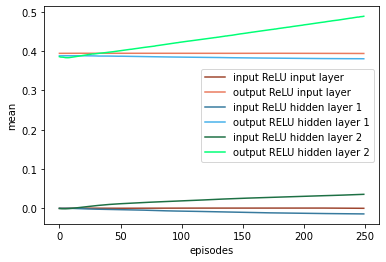

In [189]:
data1_in, data1_out = bn1_out,h1_in
# # data1_in, data1_out = input_out,h1_in
# # data2_in, data2_out = h1_out, h2_in
data2_in, data2_out = bn2_out, h2_in
data3_in, data3_out = bn_out, output_in
# data3_in, data3_out = h2_out, output_in
# we have to make the mean out of the whole train set and activation neurons
plt.plot(np.mean(data1_in.reshape(int(len(data1_in)/34),-1),axis=1),label='input ReLU input layer',color='#9E462F')
plt.plot(np.mean(data1_out.reshape(int(len(data1_out)/34),-1),axis=1),label='output ReLU input layer',color='#EB7B5E')
plt.plot(np.mean(data2_in.reshape(int(len(data2_in)/34),-1),axis=1),label='input ReLU hidden layer 1',color='#377A9E')
plt.plot(np.mean(data2_out.reshape(int(len(data2_out)/34),-1),axis=1),label='output RELU hidden layer 1',color='#46B1EB')
plt.plot(np.mean(data3_in.reshape(int(len(data3_in)/34),-1),axis=1),label='input ReLU hidden layer 2',color='#1D7044')
plt.plot(np.mean(data3_out.reshape(int(len(data3_out)/34),-1),axis=1),label='output RELU hidden layer 2',color='#00FF76')
plt.legend()
# plt.xticks(ticks=np.linspace(0,100,5),labels=np.linspace(0,250,5).astype(int))
plt.ylabel('mean')
plt.xlabel('episodes')
plt.savefig(path_graphs +run_path+ 'relu_mean_' +title + '.jpg', format='jpg', dpi=200, bbox_inches='tight')
plt.show()

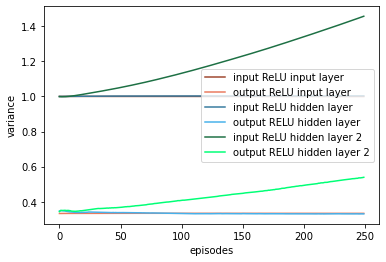

In [190]:
# we have to make the mean out of the whole train set and activation neurons
plt.plot(np.var(data1_in.reshape(int(len(data1_in)/34),-1),axis=1),label='input ReLU input layer',color='#9E462F')
plt.plot(np.var(data1_out.reshape(int(len(data1_out)/34),-1),axis=1),label='output ReLU input layer',color='#EB7B5E')
plt.plot(np.var(data2_in.reshape(int(len(data2_in)/34),-1),axis=1),label='input ReLU hidden layer',color='#377A9E')
plt.plot(np.var(data2_out.reshape(int(len(data2_out)/34),-1),axis=1),label='output RELU hidden layer',color='#46B1EB')
plt.plot(np.var(data3_in.reshape(int(len(data3_in)/34),-1),axis=1),label='input ReLU hidden layer 2',color='#1D7044')
plt.plot(np.var(data3_out.reshape(int(len(data3_out)/34),-1),axis=1),label='output RELU hidden layer 2',color='#00FF76')
plt.legend()
# plt.xticks(ticks=np.linspace(0,100,5),labels=np.linspace(0,250,5).astype(int))
plt.ylabel('variance')
plt.xlabel('episodes')
plt.savefig(path_graphs+run_path + 'relu_var_' +title + '.jpg', format='jpg', dpi=200, bbox_inches='tight')
plt.show()

In [71]:
# def plot_relu(data_plot,n_bins=20,title='',save=False):
#     linspace = np.linspace(min(data_plot[0]),max(data_plot[0])+0.1,n_bins).reshape(-1)
#     plt.figure(figsize=(8,5))
#     label = lambda x: 'output' if x%2==1 else 'input'
#     for i,d in enumerate(data_plot):
#         plt.hist(d,bins=linspace-(linspace[1]-linspace[0]),align='mid',rwidth=.8,alpha=1-(i*.5),label=label(i))
#     plt.legend(title='Relu:')
#     plt.savefig(path_graphs +run_path+title + '_reludist' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')


#### Bias and variance of the model

In [191]:
trainerror = logs.trainloss
testerror  = logs.testloss
trainerror.iloc[-1]

0.5273676575983272

In [192]:
path_graphs+run_path + 'biasvariance_' +title + '.jpg'

'F:\\TFG\\graphs\\m3_wyscout\\biasvariance_nnbn_pca_4layers_9113params_pca10.jpg'

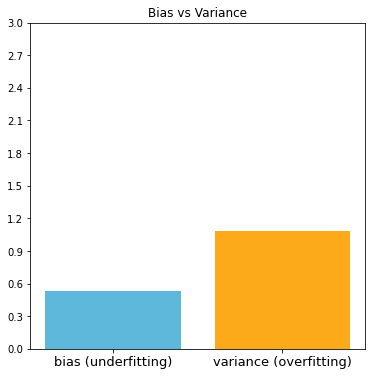

In [193]:
trainerror = logs.trainloss.iloc[-1]
testerror  = logs.testloss.iloc[-1]
biasvariance = [trainerror, testerror-trainerror]
plt.figure(figsize=(6,6))
plt.bar([1,2], biasvariance, color=['#5EB8DB','#FCAA19'])
plt.xticks([1,2],['bias (underfitting)','variance (overfitting)'],fontsize=13)
plt.yticks(np.linspace(0,3,11))
plt.title('Bias vs Variance')
plt.savefig(path_graphs+run_path + 'biasvariance_' +title + '.jpg', format='jpg', dpi=200, bbox_inches='tight')


# Complex Models: improving model/data

In [10]:
class NeuralNetworkBN(nn.Module):
    def __init__(self, input_feature, ouput_classes, hidden_neurons=[5], cross_entropy=False):
        torch.manual_seed(0)

        super().__init__()
        self.celoss = cross_entropy
        self.input = nn.Linear(in_features=input_feature, out_features=hidden_neurons[0])
        self.hidden_layers, self.hidden_bn = nn.ModuleList([]),nn.ModuleList([])
        for i in range(1,len(hidden_neurons)):
            self.hidden_bn.append(nn.BatchNorm1d(hidden_neurons[i-1]))
            self.hidden_layers.append(nn.Linear(in_features=hidden_neurons[i-1],out_features=hidden_neurons[i]))
        
        self.bn_out = nn.BatchNorm1d(hidden_neurons[-1])
        self.out = nn.Linear(hidden_neurons[-1],ouput_classes)

    def forward(self,x):
        x = self.input(x)
        for bn,layer in zip(self.hidden_bn,self.hidden_layers):
            x = layer(F.relu(bn(x)))
        x = F.relu(self.bn_out(x))
        if self.celoss: return self.out(x)
        else:           return F.softmax(self.out(x),1)    

    def reset_weights(self):
        self.input.reset_parameters()
        for bn,layer in zip(self.hidden_bn,self.hidden_layers):
            bn.reset_parameters(); layer.reset_parameters()
        self.bn_out.reset_parameters()
        self.out.reset_parameters()   

class NeuralNetworkBNClass:
    def __init__(self,traindata,hidden_neurons,loss_func,optim=torch.optim.Adam,optim_args={'lr':1e-4}):
        torch.manual_seed(0)
        # loss function
        self.loss_func   = loss_func()
        # model creation
        self.model       = NeuralNetworkBN(input_feature=traindata.data.shape[1],ouput_classes=3,hidden_neurons=hidden_neurons,cross_entropy=isinstance(self.loss_func,nn.CrossEntropyLoss))
        # register hooks -> relu input and output
        self.activation, self.gradients = {}, {}
        self.model.input.register_forward_hook(get_activation('input',self.activation)) # relu input
        self.model.input.register_full_backward_hook(get_gradients('input',self.gradients))
        self.model.out.register_forward_hook(get_activation('output',self.activation)) # relu output
        self.model.out.register_full_backward_hook(get_gradients('output',self.gradients))

        # network weights initialization
        self.weight_dist = np.copy(self.model.state_dict()['input.weight'].numpy().reshape(-1))
        # optimizer
        self.optim       = optim(params=self.model.parameters(),**optim_args)
        # Print out the architecture and number of parameters.
        print(self.model)
        self.params = sum([x.nelement() for x in self.model.parameters()])
        print(f"The model has {self.params} parameters.",end='\n')

        # assign hookers to the layers
        if len(self.model.hidden_layers)>0:
            print('There are hidden layers!')
            for i,h in enumerate(self.model.hidden_layers): 
                h.register_forward_hook(get_activation(f'h{i+1}',self.activation))
                print(f'Hidden layers hooks registered h{i+1}')
        if len(self.model.hidden_bn)>0:
            for i,h in enumerate(self.model.hidden_bn): 
                h.register_forward_hook(get_activation(f'bn{i+1}',self.activation))
                h.register_full_backward_hook(get_gradients(f'h{i+1}',self.gradients))
                print(f'Batch normalization layer hooks registered bn{i+1}')  
        self.model.bn_out.register_forward_hook(get_activation(f'bn_out',self.activation))  

In [11]:
class NeuralNetworkDropOut(nn.Module):
    def __init__(self, input_feature, ouput_classes, hidden_neurons=[5], p=.25,cross_entropy=False):
        torch.manual_seed(0)

        super().__init__()
        self.celoss = cross_entropy
        self.input = nn.Linear(in_features=input_feature, out_features=hidden_neurons[0])
        self.hidden_layers = nn.ModuleList([])
        for i in range(1,len(hidden_neurons)):
            self.hidden_layers.append(nn.Linear(in_features=hidden_neurons[i-1],out_features=hidden_neurons[i]))
        
        self.out = nn.Linear(hidden_neurons[-1],ouput_classes)

        #drop out
        self.dropout = nn.Dropout(p)

    def forward(self,x):
        x = self.dropout(x)
        x = self.input(x)
        for layer in self.hidden_layers:
            x = layer(self.dropout(F.relu(x)))
        x = F.relu(x)
        if self.celoss: return self.out(x)
        else:           return F.softmax(self.out(x),1)    

    def reset_weights(self):
        self.input.reset_parameters()
        for layer in self.hidden_layers:
            layer.reset_parameters()
        self.dropout.reset_parameters()
        self.out.reset_parameters()   

class NeuralNetworkDOClass:
    def __init__(self,traindata,hidden_neurons,loss_func,p=.25,optim=torch.optim.Adam,optim_args={'lr':1e-4}):
        torch.manual_seed(0)
        # loss function
        self.loss_func   = loss_func()
        # model creation
        self.model       = NeuralNetworkDropOut(input_feature=traindata.data.shape[1],ouput_classes=3,
                                hidden_neurons=hidden_neurons, p=p,
                                cross_entropy=isinstance(self.loss_func,nn.CrossEntropyLoss))
        # register hooks -> relu input and output
        self.activation, self.gradients = {},{}
        self.model.input.register_forward_hook(get_activation('input',self.activation)) # relu input
        self.model.input.register_full_backward_hook(get_gradients('input',self.gradients))
        self.model.out.register_forward_hook(get_activation('output',self.activation)) # relu output
        self.model.out.register_full_backward_hook(get_gradients('output',self.gradients))
        # network weights initialization
        self.weight_dist = np.copy(self.model.state_dict()['input.weight'].numpy().reshape(-1))
        # optimizer
        self.optim       = optim(params=self.model.parameters(),**optim_args)
        # Print out the architecture and number of parameters.
        print(self.model)
        self.params = sum([x.nelement() for x in self.model.parameters()])
        print(f"The model has {self.params} parameters.",end='\n')

        # assign hookers to the layers
        if len(self.model.hidden_layers)>0:
            print('There are hidden layers!')
            for i,h in enumerate(self.model.hidden_layers): 
                h.register_forward_hook(get_activation(f'h{i+1}',self.activation))
                h.register_full_backward_hook(get_gradients(f'h{i+1}',self.gradients))
                print(f'Hidden layers hooks registered h{i+1}')     

In [18]:
torch.manual_seed(0), np.random.seed(0)
batch_size = 32
# data is already shuffled (when Dataset is created)
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=SequentialSampler(traindata),drop_last=True)
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=SequentialSampler(testdata),drop_last=True)

## Test model
- Wyscout
- 443 params [10-15-3]
- No initalization
- No batch normalization
- No regularization
- Cross-Entropy Loss
- 3000 epochs

Now, it's gonna be used the whole training set instead of a single mini-batch to train the model. However, the approach will be the same as the aim is to overfit the dataset.

In this first step, the simplicity of the model will be kept. No batch normalization, regularization or weight initialization. Just the default parameter values.

Once the model is trained and the results are evaluated, the following step is the improve the model, addressing underfitting and overfitting.

In [99]:
model = dumbmodelclass(traindata,[48,18,18],nn.CrossEntropyLoss,
                    optim=torch.optim.Adam,
                    optim_args={'lr':.0001,
                                'betas':(.99,.99)
                                },
                    activation=F.relu,
                    activ_opt={'negative_slope':1e-1}
                    )

DumbNeuralNetwork(
  (input): Linear(in_features=20, out_features=48, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=48, out_features=18, bias=True)
    (1): Linear(in_features=18, out_features=18, bias=True)
  )
  (out): Linear(in_features=18, out_features=3, bias=True)
)
The model has 2289 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2


In [100]:
# complex data simple model
title=f'cdsm_{batch_size}batch_{model.params}params_sigmoid'
run_path = 'm1_wyscout\\'

In [101]:
i

0

In [102]:
len(trainloader)

34

In [103]:
importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
# ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=True)
# print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)
# print('Outputs saved succesfully!') 

Ep 250/250, it 9/34: loss train: 0.59, accuracy train: 0.59, loss test: 0.71, accuracy test: 0.46
Model trained succesfully!


relu .46

elu .44

selu .44

leakyrelu .47

sigmoid .5

tanh .44

## Complex Architecture Analysis
- Wyscout
-  params [-3]
- No Initialization
- No batch normalization
- No regularization
- Cross-Entropy Loss
- 250 epochs

### Model 1 - 4 layers ~3000 params.

In [19]:
model = dumbmodelclass(traindata,[50,30,10],nn.CrossEntropyLoss)

# complex data simple model
title=f'cdsm_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm1_wyscout\\'
print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=20, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=3, bias=True)
)
The model has 2923 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
0

Ep 250/250, it 9/34: loss train: 0.82, accuracy train: 0.64, loss test: 1.40, accuracy test: 0.48
Model trained succesfully!
Logs saved succesfully!


#### 3.1. Adding Normalization

##### Overfitting minibatch

In [32]:
len(trainloader)

1

In [34]:
model = NeuralNetworkBNClass(traindata,[50,30,10],nn.CrossEntropyLoss)

# complex data simple model
title=f'overfitting_{batch_size}batch_{model.params}params'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,1000)
print('\nModel trained succesfully!')
# ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title)
# print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=20, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=10, out_features=3, bias=True)
)
The model has 3103 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 1000/1000, it 1/1: loss train: 0.32, accuracy train: 1.00, loss test: 1.30, accuracy test: 0.38
Model trained succesfully!


It works fine!

##### Training data with Batch Normalization

In [38]:
len(trainloader)

34

In [39]:
model = NeuralNetworkBNClass(traindata,[50,30,10],nn.CrossEntropyLoss,optim_args={'lr':1e-4})

# complex data simple model
title=f'nnbn_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=False)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=20, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=10, out_features=3, bias=True)
)
The model has 3103 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.20, accuracy train: 0.96, loss test: 2.44, accuracy test: 0.40
Model trained succesfully!
Logs saved succesfully!


##### Adam w/ weight decay

In [44]:
weight_decay = .5
w_decay_str = f'_wdecay{weight_decay}'

In [45]:
model = NeuralNetworkBNClass(traindata,[50,30,10],nn.CrossEntropyLoss,optim_args={'lr':1e-4,'weight_decay':weight_decay})

# complex data simple model
title=f'nnbn_{len(model.model.hidden_layers)+2}layers_{model.params}params{w_decay_str}'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=False)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=20, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=10, out_features=3, bias=True)
)
The model has 3103 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.87, accuracy train: 0.93, loss test: 1.08, accuracy test: 0.45
Model trained succesfully!
Logs saved succesfully!


##### Drop-out regularization

In [42]:
p = .05
drop_out_str = f'_dropout{p}'

model = NeuralNetworkDOClass(traindata,[50,30,10],nn.CrossEntropyLoss,p=p,optim=torch.optim.Adam)#,optim_args={'lr':1e-4,'weight_decay':weight_decay})

# complex data simple model
title=f'nndo_{len(model.model.hidden_layers)+2}layers_{model.params}params{drop_out_str}'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=False)
print('Logs saved succesfully!\n')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkDropOut(
  (input): Linear(in_features=20, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=3, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)
The model has 2923 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Ep 250/250, it 9/34: loss train: 0.89, accuracy train: 0.58, loss test: 1.27, accuracy test: 0.49
Model trained succesfully!
Logs saved succesfully!



In [56]:
p = .25
drop_out_str = f'_dropout{p}'

model = NeuralNetworkDOClass(traindata,[50,30,10],nn.CrossEntropyLoss,p=p,optim=torch.optim.Adam)#,optim_args={'lr':1e-4,'weight_decay':weight_decay})

# complex data simple model
title=f'nndo_{len(model.model.hidden_layers)+2}layers_{model.params}params{drop_out_str}'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=False)
print('Logs saved succesfully!\n')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkDropOut(
  (input): Linear(in_features=20, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
The model has 2923 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Ep 250/250, it 9/34: loss train: 0.97, accuracy train: 0.53, loss test: 1.24, accuracy test: 0.48
Model trained succesfully!
Logs saved succesfully!



#### 3.2. Dimensionality Reduction (feature selection)

In [13]:
from sklearn import feature_selection

In [14]:
importlib.reload(ml)

traindata   = ml.WyscoutDataset('train')
testdata    = ml.WyscoutDataset('test')
traindata.features = traindata.features
old_train = traindata.data.clone()
old_test  = testdata.data.clone()
to_fit = old_train / torch.mean(old_train,dim=0).numpy()
old_feat = traindata.features.copy()
to_fit.mean(dim=0), to_fit.var(dim=0)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000]),
 tensor([0.2875, 0.2892, 0.1228, 0.1425, 0.0794, 0.0902, 0.4304, 0.5834, 0.1938,
         0.2820, 0.0724, 0.0855, 0.0025, 0.0024, 0.3011, 0.3420, 0.3194, 0.3216,
         0.3975, 0.2839]))

##### Variance Threshold

In [26]:
thres = .4
varthr_str = f'varthr{thres}'

In [27]:
filter = feature_selection.VarianceThreshold(thres).fit(to_fit)
mask_new_feat = filter.get_support()
traindata.data = old_train[:,mask_new_feat]
testdata.data  = old_test[:,mask_new_feat]
# scalling data
traindata.data = (traindata.data - torch.mean(traindata.data,axis=0)) / torch.std(traindata.data,axis=0)
testdata.data  = (testdata.data - torch.mean(testdata.data,axis=0)) / torch.std(testdata.data,axis=0)

traindata.features = np.array(old_feat)[mask_new_feat]
print(traindata.features)
torch.manual_seed(0), np.random.seed(0)
batch_size = 32
# data is already shuffled (when Dataset is created)
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=SequentialSampler(traindata),drop_last=True)
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=SequentialSampler(testdata),drop_last=True)

# # overfitting of a single batch
# batch_size = 8
# trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=np.random.randint(0,len(traindata.data),batch_size))
# testloader      = DataLoader(testdata,batch_size=batch_size,sampler=np.random.randint(0,len(testdata.data),batch_size))

['goals_H' 'goals_A']


No regularization

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [95]:
model = dumbmodelclass(traindata,[50,30,10],nn.CrossEntropyLoss)
# complex data simple model
title=f'varthr_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm3_wyscout\\'
print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=11, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=3, bias=True)
)
The model has 2473 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
0

Ep 250/250, it 9/34: loss train: 0.92, accuracy train: 0.55, loss test: 1.24, accuracy test: 0.44
Model trained succesfully!
Logs saved succesfully!


Conclusions: 
- First layers seem that they don't learn so much! grads ~ 0
- Not enough data for the model to learn
- Weight decay generaliza mucho mejor (reduce overfitting)
- Distribucion constante de los pesos e inputs/outputs de la red, excepto en el input al RELU 1.

Batch Normalization (with and wihout Weight decay)

In [96]:
model = NeuralNetworkBNClass(traindata,[50,30,10],nn.CrossEntropyLoss)

# complex data simple model
title=f'nnbn_varthr_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!\n')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=11, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=10, out_features=3, bias=True)
)
The model has 2653 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.41, accuracy train: 0.87, loss test: 1.85, accuracy test: 0.38
Model trained succesfully!

Logs saved succesfully!


Conclusiones:
- Aprendizaje mucho más rápido y eficaz.
- Overfitting muy pronunciado: ~3.85
- Distribucion constante de los pesos en la red gracias a la Batch Normalization´
- La distribucion de los gradientes cambia a lo largo del entrenamiento, a mitad del entrenamiento la media es más alta por lo que aprende másm rápido el modelo, especialmente las capas inpus y luego h0 y h1.
- El decremento del gradiente del output es posiblemente debido a la convergencia del modelo.
- Es interesante ver como con Batch Normalization los gradientes se propagan más rápidos y las primeras capas aprenden antes.

##### ANOVA

In [42]:
r0 = np.random.randint(low=3,high=10,size=(10,3))
r1 = np.random.randint(low=3,high=25,size=(10,3))
r2 = np.random.randint(low=25,high=50,size=(3,3))
r3 = np.random.randint(low=50,high=75,size=(3,3))
r4 = np.random.randint(low=75,high=100,size=(2,3))
units = np.concatenate([r0,r1,r2,r3,r4])
units = units.T
units[0] = np.random.permutation(units[0])
units[1] = np.random.permutation(units[1])
units[2] = np.random.permutation(units[2])
units3 = units.T
units3

array([[12, 17, 60],
       [84, 58, 54],
       [ 9,  8, 46],
       [20, 50, 10],
       [ 6,  7, 77],
       [56, 45, 13],
       [ 5, 98,  6],
       [ 4, 18,  4],
       [ 9,  4,  9],
       [91, 17, 32],
       [22,  5, 96],
       [ 5,  4,  4],
       [ 3,  8,  5],
       [36, 68, 52],
       [18, 12, 14],
       [ 7,  7, 32],
       [15, 39,  4],
       [16, 15, 22],
       [ 4, 14, 21],
       [12,  6, 24],
       [13,  3,  8],
       [60,  6,  9],
       [47,  3,  4],
       [36,  5,  8],
       [ 4,  4, 17],
       [ 5, 38, 24],
       [ 8, 79, 19],
       [58, 17,  5]])

In [46]:
n = 4
r0 = np.random.randint(low=3,high=10,size=(10,n))
r1 = np.random.randint(low=3,high=25,size=(10,n))
r2 = np.random.randint(low=25,high=50,size=(3,n))
r3 = np.random.randint(low=50,high=75,size=(3,n))
r4 = np.random.randint(low=75,high=100,size=(2,n))
units = np.concatenate([r0,r1,r2,r3,r4])
units = units.T
units[0] = np.random.permutation(units[0])
units[1] = np.random.permutation(units[1])
units[2] = np.random.permutation(units[2])
units[3] = np.random.permutation(units[3])
units4 = units.T
units4, len(units4)

(array([[ 3,  5,  8,  8],
        [81, 35, 17,  5],
        [ 8,  3,  9, 13],
        [26, 11, 19, 20],
        [ 5, 62, 55, 60],
        [ 5, 12,  9, 16],
        [14, 30, 15,  3],
        [ 6,  6, 92, 83],
        [10,  3, 27, 15],
        [10,  4,  3, 10],
        [ 9, 58, 33,  3],
        [ 5, 15, 12, 96],
        [10, 81,  7,  7],
        [59, 15,  4, 19],
        [13,  5, 58,  9],
        [50,  8, 16,  8],
        [56,  4, 13, 34],
        [ 4, 10,  3, 68],
        [ 3, 67,  4,  6],
        [13, 77, 65, 33],
        [77,  8, 19, 24],
        [ 3, 14, 89, 21],
        [46, 35, 38,  8],
        [11, 21,  4, 18],
        [20, 11, 23, 25],
        [31,  6, 20, 56],
        [ 8,  6,  8,  8],
        [ 7,  4,  6, 11]]),
 28)

In [36]:
units = [*units3,*units4]
len(units)

720

In [101]:
n_feats = 10
anova_str = f'_anova{n_feats}'

In [102]:
filter = feature_selection.SelectKBest(score_func=feature_selection.f_classif,k=n_feats)
filter.fit(to_fit,traindata.labels.argmax(dim=1))
mask_new_feat = filter.get_support()
traindata.data = old_train[:,mask_new_feat]
testdata.data  = old_test[:,mask_new_feat]
traindata.features = np.array(old_feat)[mask_new_feat]
# scalling data
traindata.data = (traindata.data - torch.mean(traindata.data,axis=0)) / torch.std(traindata.data,axis=0)
testdata.data  = (testdata.data - torch.mean(testdata.data,axis=0)) / torch.std(testdata.data,axis=0)

print(traindata.features)
torch.manual_seed(0), np.random.seed(0)
batch_size = 32
# data is already shuffled (when Dataset is created)
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=SequentialSampler(traindata),drop_last=True)
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=SequentialSampler(testdata),drop_last=True)

# # overfitting of a single batch
# batch_size = 8
# trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=np.random.randint(0,len(traindata.data),batch_size))
# testloader      = DataLoader(testdata,batch_size=batch_size,sampler=np.random.randint(0,len(testdata.data),batch_size))

['shots_11H' 'shots_11A' 'goals_H' 'goals_A' 'passes_11A' 'passes_acc_11A'
 'keyPasses_A' 'ataque_h' 'ataque_a' 'defensa_a']


In [99]:
model = dumbmodelclass(traindata,[50,30,10],nn.CrossEntropyLoss)
# complex data simple model
title=f'anova_{len(model.model.hidden_layers)+2}layers_{model.params}params{anova_str}'
run_path = 'm3_wyscout\\'
print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=10, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=3, bias=True)
)
The model has 2423 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
0

Ep 250/250, it 9/34: loss train: 0.91, accuracy train: 0.58, loss test: 1.26, accuracy test: 0.46
Model trained succesfully!
Logs saved succesfully!


Conclusiones w/o BN:
- Aprendizaje muy lento!

In [103]:
model = NeuralNetworkBNClass(traindata,[50,30,10],nn.CrossEntropyLoss)

# complex data simple model
title=f'nnbn_anova_{len(model.model.hidden_layers)+2}layers_{model.params}params{anova_str}'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!\n')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=10, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=10, out_features=3, bias=True)
)
The model has 2603 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.47, accuracy train: 0.84, loss test: 1.70, accuracy test: 0.43
Model trained succesfully!

Logs saved succesfully!


Conclusiones w/ BN:
- Entrenamiento practicamente idéntico al Variance Threshold con Batch Normalization.
- Como en los demás experimentos, las capas más cercanas al output aprenden más rápido, y se puede ver como tienden los pesos a una distribucion normal (tambien se observaba en el overfitting de un minibatch), lo que puede hacernos pensar que si inicializamos los pesos con He Normal, tal vez, estas capas que les cuesta más aprender, converjan antes.
- Contradictoriamente con lo anterior: la capa input recibe de media un gradiente mayor que las capas ocultas 1 y 2. Además la media del output de la capa input tiene una tendencia lineal creciente, al revés de las demás capas que su output medio es constante en ~0.4. Es posible que esto sea debido a que ReLU una funcion que solo tiene outputs positivos (o zero) ?????

##### Features selected

In [104]:
mask_selected_features = [False, False, True, True, True,
       True,True, True, False, False,
       False, False, True, True,
       False, False, True, True, True,
       True]
traindata.data = old_train[:,mask_selected_features]
testdata.data  = old_test[:,mask_selected_features]
traindata.features = np.array(old_feat)[mask_selected_features]
# scalling data
traindata.data = (traindata.data - torch.mean(traindata.data,axis=0)) / torch.std(traindata.data,axis=0)
testdata.data  = (testdata.data - torch.mean(testdata.data,axis=0)) / torch.std(testdata.data,axis=0)

print(traindata.features)
torch.manual_seed(0), np.random.seed(0)
batch_size = 32
# data is already shuffled (when Dataset is created)
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=SequentialSampler(traindata),drop_last=True)
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=SequentialSampler(testdata),drop_last=True)

# # overfitting of a single batch
# batch_size = 8
# trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=np.random.randint(0,len(traindata.data),batch_size))
# testloader      = DataLoader(testdata,batch_size=batch_size,sampler=np.random.randint(0,len(testdata.data),batch_size))

['shots_11H' 'shots_11A' 'shots_acc_11H' 'shots_acc_11A' 'goals_H'
 'goals_A' 'passes_acc_11H' 'passes_acc_11A' 'ataque_h' 'defensa_h'
 'ataque_a' 'defensa_a']


In [105]:
model = dumbmodelclass(traindata,[50,30,10],nn.CrossEntropyLoss)
# complex data simple model
title=f'featsel_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm3_wyscout\\'
print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=12, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=3, bias=True)
)
The model has 2523 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
0

Ep 250/250, it 9/34: loss train: 0.89, accuracy train: 0.59, loss test: 1.31, accuracy test: 0.45
Model trained succesfully!
Logs saved succesfully!


Conclusiones:
- El accuracy crece más rapidamente

In [106]:
model = NeuralNetworkBNClass(traindata,[50,30,10],nn.CrossEntropyLoss)

# complex data simple model
title=f'nnbn_featsel_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!\n')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=12, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=10, out_features=3, bias=True)
)
The model has 2703 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.41, accuracy train: 0.89, loss test: 1.86, accuracy test: 0.43
Model trained succesfully!

Logs saved succesfully!


##### PCA

In [107]:
from sklearn.decomposition import PCA

In [108]:
n_dim = 10
pca_str = f'_pca{n_dim}'

pca = PCA(n_components=n_dim,random_state=0)
# to_fit = old_train - old_train.mean(dim=0)
to_fit = old_train
pca = pca.fit(X=to_fit)
traindata.data = torch.tensor(pca.transform(old_train)).float()
testdata.data  = torch.tensor(pca.transform(old_test)).float()
traindata.features = np.arange(n_dim)+1
print(traindata.features)

torch.manual_seed(0), np.random.seed(0)
batch_size = 32
# data is already shuffled (when Dataset is created)
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=SequentialSampler(traindata),drop_last=True)
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=SequentialSampler(testdata),drop_last=True)

# # overfitting of a single batch
# batch_size = 8
# trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=np.random.randint(0,len(traindata.data),batch_size))
# testloader      = DataLoader(testdata,batch_size=batch_size,sampler=np.random.randint(0,len(testdata.data),batch_size))

[ 1  2  3  4  5  6  7  8  9 10]


In [ ]:
# with zero meam
traindata.data.mean(dim=0), traindata.data.var(dim=0)

(tensor([ 1.6240e+03, -1.2978e+02, -3.1630e+01,  4.9505e+00, -1.2225e+00,
          3.8184e+00, -7.5153e-01, -3.5695e-02, -2.4747e-01, -5.3905e-01]),
 tensor([1.1219e+05, 9.5794e+04, 1.0964e+03, 7.8630e+01, 5.7128e+01, 5.1803e+01,
         8.6880e+00, 5.9701e+00, 4.3812e+00, 3.1140e+00]))

In [109]:
# without zeroing mean
traindata.data.mean(dim=0), traindata.data.var(dim=0)

(tensor([ 6.6584e-07,  6.6584e-07, -5.5487e-08, -2.7743e-08,  2.0807e-08,
         -4.1615e-08,  1.7340e-09,  0.0000e+00,  1.0404e-08,  1.7340e-09]),
 tensor([1.1219e+05, 9.5794e+04, 1.0964e+03, 7.8630e+01, 5.7128e+01, 5.1803e+01,
         8.6880e+00, 5.9701e+00, 4.3812e+00, 3.1140e+00]))

In [110]:
model = dumbmodelclass(traindata,[50,30,10],nn.CrossEntropyLoss)
# complex data simple model
title=f'pca_{len(model.model.hidden_layers)+2}layers_{model.params}params{pca_str}'
run_path = 'm3_wyscout\\'
print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=10, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (out): Linear(in_features=10, out_features=3, bias=True)
)
The model has 2423 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
0

Ep 250/250, it 9/34: loss train: 0.91, accuracy train: 0.57, loss test: 1.24, accuracy test: 0.47
Model trained succesfully!
Logs saved succesfully!


In [111]:
model = NeuralNetworkBNClass(traindata,[50,30,10],nn.CrossEntropyLoss)

# complex data simple model
title=f'nnbn_pca_{len(model.model.hidden_layers)+2}layers_{model.params}params{pca_str}'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!\n')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=10, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=10, out_features=3, bias=True)
)
The model has 2603 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.79, accuracy train: 0.65, loss test: 1.35, accuracy test: 0.42
Model trained succesfully!

Logs saved succesfully!


### Model 2 - 3 layers ~5000 params.

In [17]:
model = dumbmodelclass(traindata,[70,45],nn.CrossEntropyLoss)

# complex data simple model
title=f'cdsm_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm1_wyscout\\'
print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=20, out_features=70, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=70, out_features=45, bias=True)
  )
  (out): Linear(in_features=45, out_features=3, bias=True)
)
The model has 4803 parameters.
There are hidden layers!
Hook registered h1
0

Ep 250/250, it 9/34: loss train: 0.76, accuracy train: 0.69, loss test: 1.42, accuracy test: 0.45
Model trained succesfully!
Logs saved succesfully!



### Model 3 - 4 layers ~10000 params.

### Model 4 - 4 layers ~700 params.

In [50]:
model = dumbmodelclass(traindata,[20,10,5],nn.CrossEntropyLoss)

# complex data simple model
title=f'cdsm_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm4_wyscout\\'
print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=20, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (out): Linear(in_features=5, out_features=3, bias=True)
)
The model has 703 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
0

Ep 250/250, it 9/34: loss train: 0.93, accuracy train: 0.55, loss test: 1.23, accuracy test: 0.49
Model trained succesfully!
Logs saved succesfully!


A partir del modelo 3, intentar reducir el underfitting y overfitting a partir de cambias hiperparámetros, regularizacion...


#### 3.1. Adding Normalization

##### Training data with Batch Normalization

In [51]:
len(trainloader)

34

In [52]:
model = NeuralNetworkBNClass(traindata,[20,10,5],nn.CrossEntropyLoss,optim_args={'lr':1e-4})

# complex data simple model
title=f'nnbn_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm4_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=False)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=20, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=5, out_features=3, bias=True)
)
The model has 773 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.82, accuracy train: 0.60, loss test: 1.35, accuracy test: 0.42
Model trained succesfully!
Logs saved succesfully!


El overfitting no es que no haya bajado sino que ha aumentado considerablemente.

**ANALIZAR ERROR, WEIGHTS...**

SOLUCIONES: 
- Aplicar regularizacion: L2, weight decay, dropout (desactivando Batch Normalization), etc.
- Reducir tamaño del modelo
- Aumentar tamaño de los datos
- Reduccion de dimensionalidad !!!

##### Adam w/ weight decay

In [55]:
weight_decay = .5
w_decay_str = f'_wdecay{weight_decay}'

In [56]:
model = NeuralNetworkBNClass(traindata,[20,10,5],nn.CrossEntropyLoss,optim_args={'lr':1e-4,'weight_decay':weight_decay})

# complex data simple model
title=f'nnbn_{len(model.model.hidden_layers)+2}layers_{model.params}params{w_decay_str}'
run_path = 'm4_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=20, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=5, out_features=3, bias=True)
)
The model has 773 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 1.03, accuracy train: 0.48, loss test: 1.08, accuracy test: 0.47
Model trained succesfully!
Logs saved succesfully!


El weight decay no da los resultados esperados y aunque reduce drasticamente el overfitting, el modelo no generaliza nada bien (gran underfitting). Esto es posible que sea debido al pequeño numero de samples que disponemos, y más aun en relación con el tamaño de la red.

- 1 - Probar weight_decays más pequeños
- 2 - Otros metodos regularizacion
- 3 - Feature selection
- 4 - Reducir tamaño modelo

##### Drop-out regularization

In [57]:
p = .05
drop_out_str = f'_dropout{p}'

model = NeuralNetworkDOClass(traindata,[20,10,5],nn.CrossEntropyLoss,p=p,optim=torch.optim.Adam)#,optim_args={'lr':1e-4,'weight_decay':weight_decay})

# complex data simple model
title=f'nndo_{len(model.model.hidden_layers)+2}layers_{model.params}params{drop_out_str}'
run_path = 'm4_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=False)
print('Logs saved succesfully!\n')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkDropOut(
  (input): Linear(in_features=20, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (out): Linear(in_features=5, out_features=3, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)
The model has 703 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Ep 250/250, it 9/34: loss train: 0.96, accuracy train: 0.53, loss test: 1.20, accuracy test: 0.49
Model trained succesfully!
Logs saved succesfully!



In [58]:
p = .25
drop_out_str = f'_dropout{p}'

model = NeuralNetworkDOClass(traindata,[20,10,5],nn.CrossEntropyLoss,p=p,optim=torch.optim.Adam)#,optim_args={'lr':1e-4,'weight_decay':weight_decay})

# complex data simple model
title=f'nndo_{len(model.model.hidden_layers)+2}layers_{model.params}params{drop_out_str}'
run_path = 'm4_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!\n')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkDropOut(
  (input): Linear(in_features=20, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (out): Linear(in_features=5, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
The model has 703 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Ep 250/250, it 9/34: loss train: 1.00, accuracy train: 0.50, loss test: 1.14, accuracy test: 0.50
Model trained succesfully!
Logs saved succesfully!



Drop-out conclusiones:
- Entrenamiento mucho más lento (tarda más la red en aprender)
- Efectivamente crea mucho menos overfitting pero tambien el underfitting es mayor
- Tal vez el underfitting o el rendimiento se pueda acelerar con un learning-rate mayor (hyperparameter tuning)
- Cuanto mas alto es el valor de p en drop-out más erratico es el aprendimiento.

#### 3.2. Dimensionality Reduction (feature selection)

In [59]:
from sklearn import feature_selection

In [60]:
importlib.reload(ml)

traindata   = ml.WyscoutDataset('train')
testdata    = ml.WyscoutDataset('test')
traindata.features = traindata.features
old_train = traindata.data.clone()
old_test  = testdata.data.clone()
to_fit = old_train / torch.mean(old_train,dim=0).numpy()
old_feat = traindata.features.copy()
to_fit.mean(dim=0), to_fit.var(dim=0)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000]),
 tensor([0.2875, 0.2892, 0.1228, 0.1425, 0.0794, 0.0902, 0.4304, 0.5834, 0.1938,
         0.2820, 0.0724, 0.0855, 0.0025, 0.0024, 0.3011, 0.3420, 0.3194, 0.3216,
         0.3975, 0.2839]))

##### Variance Threshold

In [61]:
thres = .25
varthr_str = f'varthr{thres}'

In [62]:
filter = feature_selection.VarianceThreshold(thres).fit(to_fit)
mask_new_feat = filter.get_support()
traindata.data = old_train[:,mask_new_feat]
testdata.data  = old_test[:,mask_new_feat]
# scalling data
traindata.data = (traindata.data - torch.mean(traindata.data,axis=0)) / torch.std(traindata.data,axis=0)
testdata.data  = (testdata.data - torch.mean(testdata.data,axis=0)) / torch.std(testdata.data,axis=0)

traindata.features = np.array(old_feat)[mask_new_feat]
print(traindata.features)
torch.manual_seed(0), np.random.seed(0)
batch_size = 32
# data is already shuffled (when Dataset is created)
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=SequentialSampler(traindata),drop_last=True)
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=SequentialSampler(testdata),drop_last=True)

# # overfitting of a single batch
# batch_size = 8
# trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=np.random.randint(0,len(traindata.data),batch_size))
# testloader      = DataLoader(testdata,batch_size=batch_size,sampler=np.random.randint(0,len(testdata.data),batch_size))

['mins4_H' 'mins4_A' 'goals_H' 'goals_A' 'goals_ratio_A' 'keyPasses_H'
 'keyPasses_A' 'ataque_h' 'defensa_h' 'ataque_a' 'defensa_a']


No regularization

In [63]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [64]:
model = dumbmodelclass(traindata,[20,10,5],nn.CrossEntropyLoss)
# complex data simple model
title=f'varthr_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm4_wyscout\\'
# print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=11, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (out): Linear(in_features=5, out_features=3, bias=True)
)
The model has 523 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
Ep 250/250, it 9/34: loss train: 0.98, accuracy train: 0.52, loss test: 1.18, accuracy test: 0.47
Model trained succesfully!
Logs saved succesfully!


Conclusions: 
- First layers seem that they don't learn so much! grads ~ 0
- Not enough data for the model to learn
- Weight decay generaliza mucho mejor (reduce overfitting)
- Distribucion constante de los pesos e inputs/outputs de la red, excepto en el input al RELU 1.

Batch Normalization (with and wihout Weight decay)

In [65]:
model = NeuralNetworkBNClass(traindata,[20,10,5],nn.CrossEntropyLoss)

# complex data simple model
title=f'nnbn_varthr_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm4_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!\n')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=11, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=5, out_features=3, bias=True)
)
The model has 593 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.88, accuracy train: 0.59, loss test: 1.29, accuracy test: 0.41
Model trained succesfully!

Logs saved succesfully!


Conclusiones:
- Aprendizaje mucho más rápido y eficaz.
- Overfitting muy pronunciado: ~3.85
- Distribucion constante de los pesos en la red gracias a la Batch Normalization´
- La distribucion de los gradientes cambia a lo largo del entrenamiento, a mitad del entrenamiento la media es más alta por lo que aprende másm rápido el modelo, especialmente las capas inpus y luego h0 y h1.
- El decremento del gradiente del output es posiblemente debido a la convergencia del modelo.
- Es interesante ver como con Batch Normalization los gradientes se propagan más rápidos y las primeras capas aprenden antes.

##### ANOVA

In [66]:
n_feats = 10
anova_str = f'_anova{n_feats}'

In [67]:
filter = feature_selection.SelectKBest(score_func=feature_selection.f_classif,k=n_feats)
filter.fit(to_fit,traindata.labels.argmax(dim=1))
mask_new_feat = filter.get_support()
traindata.data = old_train[:,mask_new_feat]
testdata.data  = old_test[:,mask_new_feat]
traindata.features = np.array(old_feat)[mask_new_feat]
# scalling data
traindata.data = (traindata.data - torch.mean(traindata.data,axis=0)) / torch.std(traindata.data,axis=0)
testdata.data  = (testdata.data - torch.mean(testdata.data,axis=0)) / torch.std(testdata.data,axis=0)

print(traindata.features)
torch.manual_seed(0), np.random.seed(0)
batch_size = 32
# data is already shuffled (when Dataset is created)
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=SequentialSampler(traindata),drop_last=True)
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=SequentialSampler(testdata),drop_last=True)

# # overfitting of a single batch
# batch_size = 8
# trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=np.random.randint(0,len(traindata.data),batch_size))
# testloader      = DataLoader(testdata,batch_size=batch_size,sampler=np.random.randint(0,len(testdata.data),batch_size))

['shots_11H' 'shots_11A' 'goals_H' 'goals_A' 'passes_11A' 'passes_acc_11A'
 'keyPasses_A' 'ataque_h' 'ataque_a' 'defensa_a']


In [68]:
model = dumbmodelclass(traindata,[20,10,5],nn.CrossEntropyLoss)
# complex data simple model
title=f'anova_{len(model.model.hidden_layers)+2}layers_{model.params}params{anova_str}'
run_path = 'm4_wyscout\\'
print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=10, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (out): Linear(in_features=5, out_features=3, bias=True)
)
The model has 503 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
0

Ep 250/250, it 9/34: loss train: 0.97, accuracy train: 0.53, loss test: 1.20, accuracy test: 0.48
Model trained succesfully!
Logs saved succesfully!


Conclusiones w/o BN:
- Aprendizaje muy lento!

In [69]:
model = NeuralNetworkBNClass(traindata,[20,10,5],nn.CrossEntropyLoss)

# complex data simple model
title=f'nnbn_anova_{len(model.model.hidden_layers)+2}layers_{model.params}params{anova_str}'
run_path = 'm4_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!\n')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=10, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=5, out_features=3, bias=True)
)
The model has 573 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.89, accuracy train: 0.59, loss test: 1.25, accuracy test: 0.49
Model trained succesfully!

Logs saved succesfully!


Conclusiones w/ BN:
- Entrenamiento practicamente idéntico al Variance Threshold con Batch Normalization.
- Como en los demás experimentos, las capas más cercanas al output aprenden más rápido, y se puede ver como tienden los pesos a una distribucion normal (tambien se observaba en el overfitting de un minibatch), lo que puede hacernos pensar que si inicializamos los pesos con He Normal, tal vez, estas capas que les cuesta más aprender, converjan antes.
- Contradictoriamente con lo anterior: la capa input recibe de media un gradiente mayor que las capas ocultas 1 y 2. Además la media del output de la capa input tiene una tendencia lineal creciente, al revés de las demás capas que su output medio es constante en ~0.4. Es posible que esto sea debido a que ReLU una funcion que solo tiene outputs positivos (o zero) ?????

##### Features selected

In [70]:
mask_selected_features = [False, False, True, True, True,
       True,True, True, False, False,
       False, False, True, True,
       False, False, True, True, True,
       True]
traindata.data = old_train[:,mask_selected_features]
testdata.data  = old_test[:,mask_selected_features]
traindata.features = np.array(old_feat)[mask_selected_features]
# scalling data
traindata.data = (traindata.data - torch.mean(traindata.data,axis=0)) / torch.std(traindata.data,axis=0)
testdata.data  = (testdata.data - torch.mean(testdata.data,axis=0)) / torch.std(testdata.data,axis=0)

print(traindata.features)
torch.manual_seed(0), np.random.seed(0)
batch_size = 32
# data is already shuffled (when Dataset is created)
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=SequentialSampler(traindata),drop_last=True)
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=SequentialSampler(testdata),drop_last=True)

# # overfitting of a single batch
# batch_size = 8
# trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=np.random.randint(0,len(traindata.data),batch_size))
# testloader      = DataLoader(testdata,batch_size=batch_size,sampler=np.random.randint(0,len(testdata.data),batch_size))

['shots_11H' 'shots_11A' 'shots_acc_11H' 'shots_acc_11A' 'goals_H'
 'goals_A' 'passes_acc_11H' 'passes_acc_11A' 'ataque_h' 'defensa_h'
 'ataque_a' 'defensa_a']


In [71]:
model = dumbmodelclass(traindata,[20,10,5],nn.CrossEntropyLoss)
# complex data simple model
title=f'featsel_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm4_wyscout\\'
# print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=12, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (out): Linear(in_features=5, out_features=3, bias=True)
)
The model has 543 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
Ep 250/250, it 9/34: loss train: 0.96, accuracy train: 0.55, loss test: 1.22, accuracy test: 0.48
Model trained succesfully!
Logs saved succesfully!


Conclusiones:
- El accuracy crece más rapidamente

In [72]:
model = NeuralNetworkBNClass(traindata,[20,10,5],nn.CrossEntropyLoss)

# complex data simple model
title=f'nnbn_featsel_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm4_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!\n')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=12, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=5, out_features=3, bias=True)
)
The model has 613 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.84, accuracy train: 0.57, loss test: 1.30, accuracy test: 0.43
Model trained succesfully!

Logs saved succesfully!


##### PCA

In [73]:
from sklearn.decomposition import PCA

In [74]:
n_dim = 10
pca_str = f'_pca{n_dim}'

pca = PCA(n_components=n_dim,random_state=0)
# to_fit = old_train - old_train.mean(dim=0)
to_fit = old_train
pca = pca.fit(X=to_fit)
traindata.data = torch.tensor(pca.transform(old_train)).float()
testdata.data  = torch.tensor(pca.transform(old_test)).float()
traindata.features = np.arange(n_dim)+1
print(traindata.features)

torch.manual_seed(0), np.random.seed(0)
batch_size = 32
# data is already shuffled (when Dataset is created)
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=SequentialSampler(traindata),drop_last=True)
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=SequentialSampler(testdata),drop_last=True)

# # overfitting of a single batch
# batch_size = 8
# trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=np.random.randint(0,len(traindata.data),batch_size))
# testloader      = DataLoader(testdata,batch_size=batch_size,sampler=np.random.randint(0,len(testdata.data),batch_size))

[ 1  2  3  4  5  6  7  8  9 10]


In [ ]:
# with zero meam
traindata.data.mean(dim=0), traindata.data.var(dim=0)

(tensor([ 6.6584e-07,  6.6584e-07, -5.5487e-08, -2.7743e-08,  2.0807e-08,
         -4.1615e-08,  1.7340e-09,  0.0000e+00,  1.0404e-08,  1.7340e-09]),
 tensor([1.1219e+05, 9.5794e+04, 1.0964e+03, 7.8630e+01, 5.7128e+01, 5.1803e+01,
         8.6880e+00, 5.9701e+00, 4.3812e+00, 3.1140e+00]))

In [75]:
# without zeroing mean
traindata.data.mean(dim=0), traindata.data.var(dim=0)

(tensor([ 6.6584e-07,  6.6584e-07, -5.5487e-08, -2.7743e-08,  2.0807e-08,
         -4.1615e-08,  1.7340e-09,  0.0000e+00,  1.0404e-08,  1.7340e-09]),
 tensor([1.1219e+05, 9.5794e+04, 1.0964e+03, 7.8630e+01, 5.7128e+01, 5.1803e+01,
         8.6880e+00, 5.9701e+00, 4.3812e+00, 3.1140e+00]))

In [76]:
model = dumbmodelclass(traindata,[20,10,5],nn.CrossEntropyLoss)
# complex data simple model
title=f'pca_{len(model.model.hidden_layers)+2}layers_{model.params}params{pca_str}'
run_path = 'm4_wyscout\\'
# print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=10, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (out): Linear(in_features=5, out_features=3, bias=True)
)
The model has 503 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
Ep 250/250, it 9/34: loss train: 1.02, accuracy train: 0.47, loss test: 1.12, accuracy test: 0.45
Model trained succesfully!
Logs saved succesfully!


In [77]:
model = NeuralNetworkBNClass(traindata,[20,10,5],nn.CrossEntropyLoss)

# complex data simple model
title=f'nnbn_pca_{len(model.model.hidden_layers)+2}layers_{model.params}params{pca_str}'
run_path = 'm4_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!\n')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=10, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=5, out_features=3, bias=True)
)
The model has 573 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.95, accuracy train: 0.51, loss test: 1.20, accuracy test: 0.45
Model trained succesfully!

Logs saved succesfully!


In [47]:
model = dumbmodelclass(traindata,[120,50,25],nn.CrossEntropyLoss)

# complex data simple model
title=f'cdsm_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm1_wyscout\\'
print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
# ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=True)
# print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=20, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (out): Linear(in_features=25, out_features=3, bias=True)
)
The model has 9923 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
0

Ep 250/250, it 9/34: loss train: 0.35, accuracy train: 0.90, loss test: 2.20, accuracy test: 0.41
Model trained succesfully!


A partir del modelo 3, intentar reducir el underfitting y overfitting a partir de cambias hiperparámetros, regularizacion...


#### 3.1. Adding Normalization

##### Overfitting minibatch

In [39]:
len(trainloader)

1

In [43]:
i

0

In [45]:
model = NeuralNetworkDOClass(traindata,[120,50,25],nn.CrossEntropyLoss,p=.25)

# complex data simple model
title=f'overfitting_{batch_size}batch_{model.params}params'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,1000)
print('\nModel trained succesfully!')
# ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title)
# print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkDropOut(
  (input): Linear(in_features=22, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (out): Linear(in_features=25, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
The model has 10163 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Ep 1000/1000, it 1/1: loss train: 0.00, accuracy train: 1.00, loss test: 3.62, accuracy test: 0.12
Model trained succesfully!


It works fine!

##### Training data with Batch Normalization

In [50]:
len(trainloader)

34

In [46]:
model = NeuralNetworkBNClass(traindata,[120,50,25],nn.CrossEntropyLoss,optim_args={'lr':1e-4})

# complex data simple model
title=f'nnbn_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
# ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=True)
# print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=20, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=25, out_features=3, bias=True)
)
The model has 10313 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.00, accuracy train: 1.00, loss test: 4.39, accuracy test: 0.38
Model trained succesfully!


El overfitting no es que no haya bajado sino que ha aumentado considerablemente.

**ANALIZAR ERROR, WEIGHTS...**

SOLUCIONES: 
- Aplicar regularizacion: L2, weight decay, dropout (desactivando Batch Normalization), etc.
- Reducir tamaño del modelo
- Aumentar tamaño de los datos
- Reduccion de dimensionalidad !!!

##### Adam w/ weight decay

In [47]:
weight_decay = 2.
w_decay_str = f'_wdecay{weight_decay}'

In [49]:
model = NeuralNetworkBNClass(traindata,[120,50,25],nn.CrossEntropyLoss,optim_args={'lr':1e-4,'weight_decay':weight_decay})

# complex data simple model
title=f'nnbn_{len(model.model.hidden_layers)+2}layers_{model.params}params{w_decay_str}'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
# ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=True)
# print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=20, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=25, out_features=3, bias=True)
)
The model has 10313 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 1.09, accuracy train: 0.46, loss test: 1.09, accuracy test: 0.45
Model trained succesfully!


El weight decay no da los resultados esperados y aunque reduce drasticamente el overfitting, el modelo no generaliza nada bien (gran underfitting). Esto es posible que sea debido al pequeño numero de samples que disponemos, y más aun en relación con el tamaño de la red.

- 1 - Probar weight_decays más pequeños
- 2 - Otros metodos regularizacion
- 3 - Feature selection
- 4 - Reducir tamaño modelo

##### Drop-out regularization

In [21]:
p = .05
drop_out_str = f'_dropout{p}'

model = NeuralNetworkDOClass(traindata,[120,50,25],nn.CrossEntropyLoss,p=p,optim=torch.optim.Adam)#,optim_args={'lr':1e-4,'weight_decay':weight_decay})

# complex data simple model
title=f'nndo_{len(model.model.hidden_layers)+2}layers_{model.params}params{drop_out_str}'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=False)
print('Logs saved succesfully!\n')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkDropOut(
  (input): Linear(in_features=20, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (out): Linear(in_features=25, out_features=3, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)
The model has 9923 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Ep 250/250, it 9/34: loss train: 1.03, accuracy train: 0.48, loss test: 1.11, accuracy test: 0.52
Model trained succesfully!
Logs saved succesfully!



In [43]:
p = .25
drop_out_str = f'_dropout{p}'

model = NeuralNetworkDOClass(traindata,[120,50,25],nn.CrossEntropyLoss,p=p,optim=torch.optim.Adam)#,optim_args={'lr':1e-4,'weight_decay':weight_decay})

# complex data simple model
title=f'nndo_{len(model.model.hidden_layers)+2}layers_{model.params}params{drop_out_str}'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
# ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=True)
# print('Logs saved succesfully!\n')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkDropOut(
  (input): Linear(in_features=20, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (out): Linear(in_features=25, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
The model has 9923 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Ep 250/250, it 9/34: loss train: 0.95, accuracy train: 0.53, loss test: 1.27, accuracy test: 0.48
Model trained succesfully!


Drop-out conclusiones:
- Entrenamiento mucho más lento (tarda más la red en aprender)
- Efectivamente crea mucho menos overfitting pero tambien el underfitting es mayor
- Tal vez el underfitting o el rendimiento se pueda acelerar con un learning-rate mayor (hyperparameter tuning)
- Cuanto mas alto es el valor de p en drop-out más erratico es el aprendimiento.

#### 3.2. Dimensionality Reduction (feature selection)

In [57]:
from sklearn import feature_selection

In [58]:
importlib.reload(ml)

traindata   = ml.WyscoutDataset('train')
testdata    = ml.WyscoutDataset('test')
traindata.features = traindata.features
old_train = traindata.data.clone()
old_test  = testdata.data.clone()
to_fit = old_train / torch.mean(old_train,dim=0).numpy()
old_feat = traindata.features.copy()
to_fit.mean(dim=0), to_fit.var(dim=0)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000]),
 tensor([0.2875, 0.2892, 0.1228, 0.1425, 0.0794, 0.0902, 0.4304, 0.5834, 0.1938,
         0.2820, 0.0724, 0.0855, 0.0025, 0.0024, 0.3011, 0.3420, 0.3194, 0.3216,
         0.3975, 0.2839]))

##### Variance Threshold

In [59]:
thres = .25
varthr_str = f'varthr{thres}'

In [60]:
filter = feature_selection.VarianceThreshold(thres).fit(to_fit)
mask_new_feat = filter.get_support()
traindata.data = old_train[:,mask_new_feat]
testdata.data  = old_test[:,mask_new_feat]
# scalling data
traindata.data = (traindata.data - torch.mean(traindata.data,axis=0)) / torch.std(traindata.data,axis=0)
testdata.data  = (testdata.data - torch.mean(testdata.data,axis=0)) / torch.std(testdata.data,axis=0)

traindata.features = np.array(old_feat)[mask_new_feat]
print(traindata.features)
torch.manual_seed(0), np.random.seed(0)
batch_size = 32
# data is already shuffled (when Dataset is created)
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=SequentialSampler(traindata),drop_last=True)
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=SequentialSampler(testdata),drop_last=True)

# # overfitting of a single batch
# batch_size = 8
# trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=np.random.randint(0,len(traindata.data),batch_size))
# testloader      = DataLoader(testdata,batch_size=batch_size,sampler=np.random.randint(0,len(testdata.data),batch_size))

['mins4_H' 'mins4_A' 'goals_H' 'goals_A' 'goals_ratio_A' 'keyPasses_H'
 'keyPasses_A' 'ataque_h' 'defensa_h' 'ataque_a' 'defensa_a']


No regularization

In [115]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [61]:
model = dumbmodelclass(traindata,[120,50,25],nn.CrossEntropyLoss)
# complex data simple model
title=f'varthr_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm3_wyscout\\'
print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=11, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (out): Linear(in_features=25, out_features=3, bias=True)
)
The model has 8843 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
0

Ep 250/250, it 9/34: loss train: 0.67, accuracy train: 0.72, loss test: 1.58, accuracy test: 0.41
Model trained succesfully!
Logs saved succesfully!


Conclusions: 
- First layers seem that they don't learn so much! grads ~ 0
- Not enough data for the model to learn
- Weight decay generaliza mucho mejor (reduce overfitting)
- Distribucion constante de los pesos e inputs/outputs de la red, excepto en el input al RELU 1.

Batch Normalization (with and wihout Weight decay)

In [62]:
model = NeuralNetworkBNClass(traindata,[120,50,25],nn.CrossEntropyLoss)

# complex data simple model
title=f'nnbn_varthr_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!\n')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=11, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=25, out_features=3, bias=True)
)
The model has 9233 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.01, accuracy train: 1.00, loss test: 3.85, accuracy test: 0.36
Model trained succesfully!

Logs saved succesfully!


Conclusiones:
- Aprendizaje mucho más rápido y eficaz.
- Overfitting muy pronunciado: ~3.85
- Distribucion constante de los pesos en la red gracias a la Batch Normalization´
- La distribucion de los gradientes cambia a lo largo del entrenamiento, a mitad del entrenamiento la media es más alta por lo que aprende másm rápido el modelo, especialmente las capas inpus y luego h0 y h1.
- El decremento del gradiente del output es posiblemente debido a la convergencia del modelo.
- Es interesante ver como con Batch Normalization los gradientes se propagan más rápidos y las primeras capas aprenden antes.

##### ANOVA

In [82]:
n_feats = 10
anova_str = f'_anova{n_feats}'

In [83]:
filter = feature_selection.SelectKBest(score_func=feature_selection.f_classif,k=n_feats)
filter.fit(to_fit,traindata.labels.argmax(dim=1))
mask_new_feat = filter.get_support()
traindata.data = old_train[:,mask_new_feat]
testdata.data  = old_test[:,mask_new_feat]
traindata.features = np.array(old_feat)[mask_new_feat]
# scalling data
traindata.data = (traindata.data - torch.mean(traindata.data,axis=0)) / torch.std(traindata.data,axis=0)
testdata.data  = (testdata.data - torch.mean(testdata.data,axis=0)) / torch.std(testdata.data,axis=0)

print(traindata.features)
torch.manual_seed(0), np.random.seed(0)
batch_size = 32
# data is already shuffled (when Dataset is created)
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=SequentialSampler(traindata),drop_last=True)
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=SequentialSampler(testdata),drop_last=True)

# # overfitting of a single batch
# batch_size = 8
# trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=np.random.randint(0,len(traindata.data),batch_size))
# testloader      = DataLoader(testdata,batch_size=batch_size,sampler=np.random.randint(0,len(testdata.data),batch_size))

['shots_11H' 'shots_11A' 'goals_H' 'goals_A' 'passes_11A' 'passes_acc_11A'
 'keyPasses_A' 'ataque_h' 'ataque_a' 'defensa_a']


In [65]:
model = dumbmodelclass(traindata,[120,50,25],nn.CrossEntropyLoss)
# complex data simple model
title=f'anova_{len(model.model.hidden_layers)+2}layers_{model.params}params{anova_str}'
run_path = 'm3_wyscout\\'
print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=10, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (out): Linear(in_features=25, out_features=3, bias=True)
)
The model has 8723 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
0

Ep 250/250, it 9/34: loss train: 0.76, accuracy train: 0.69, loss test: 1.38, accuracy test: 0.47
Model trained succesfully!
Logs saved succesfully!


Conclusiones w/o BN:
- Aprendizaje muy lento!

In [81]:
model = NeuralNetworkBNClass(traindata,[120,50,25],nn.CrossEntropyLoss)

# complex data simple model
title=f'nnbn_anova_{len(model.model.hidden_layers)+2}layers_{model.params}params{anova_str}'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!\n')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=10, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=25, out_features=3, bias=True)
)
The model has 9113 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.02, accuracy train: 1.00, loss test: 3.66, accuracy test: 0.40
Model trained succesfully!

Logs saved succesfully!


Conclusiones w/ BN:
- Entrenamiento practicamente idéntico al Variance Threshold con Batch Normalization.
- Como en los demás experimentos, las capas más cercanas al output aprenden más rápido, y se puede ver como tienden los pesos a una distribucion normal (tambien se observaba en el overfitting de un minibatch), lo que puede hacernos pensar que si inicializamos los pesos con He Normal, tal vez, estas capas que les cuesta más aprender, converjan antes.
- Contradictoriamente con lo anterior: la capa input recibe de media un gradiente mayor que las capas ocultas 1 y 2. Además la media del output de la capa input tiene una tendencia lineal creciente, al revés de las demás capas que su output medio es constante en ~0.4. Es posible que esto sea debido a que ReLU una funcion que solo tiene outputs positivos (o zero) ?????

##### Features selected

In [67]:
mask_selected_features = [False, False, True, True, True,
       True,True, True, False, False,
       False, False, True, True,
       False, False, True, True, True,
       True]
traindata.data = old_train[:,mask_selected_features]
testdata.data  = old_test[:,mask_selected_features]
traindata.features = np.array(old_feat)[mask_selected_features]
# scalling data
traindata.data = (traindata.data - torch.mean(traindata.data,axis=0)) / torch.std(traindata.data,axis=0)
testdata.data  = (testdata.data - torch.mean(testdata.data,axis=0)) / torch.std(testdata.data,axis=0)

print(traindata.features)
torch.manual_seed(0), np.random.seed(0)
batch_size = 32
# data is already shuffled (when Dataset is created)
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=SequentialSampler(traindata),drop_last=True)
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=SequentialSampler(testdata),drop_last=True)

# # overfitting of a single batch
# batch_size = 8
# trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=np.random.randint(0,len(traindata.data),batch_size))
# testloader      = DataLoader(testdata,batch_size=batch_size,sampler=np.random.randint(0,len(testdata.data),batch_size))

['shots_11H' 'shots_11A' 'shots_acc_11H' 'shots_acc_11A' 'goals_H'
 'goals_A' 'passes_acc_11H' 'passes_acc_11A' 'ataque_h' 'defensa_h'
 'ataque_a' 'defensa_a']


In [68]:
model = dumbmodelclass(traindata,[120,50,25],nn.CrossEntropyLoss)
# complex data simple model
title=f'featsel_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm3_wyscout\\'
print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=12, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (out): Linear(in_features=25, out_features=3, bias=True)
)
The model has 8963 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
0

Ep 250/250, it 9/34: loss train: 0.59, accuracy train: 0.78, loss test: 1.55, accuracy test: 0.42
Model trained succesfully!
Logs saved succesfully!


Conclusiones:
- El accuracy crece más rapidamente

In [69]:
model = NeuralNetworkBNClass(traindata,[120,50,25],nn.CrossEntropyLoss)

# complex data simple model
title=f'nnbn_featsel_{len(model.model.hidden_layers)+2}layers_{model.params}params'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!\n')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=12, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=25, out_features=3, bias=True)
)
The model has 9353 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.01, accuracy train: 1.00, loss test: 3.93, accuracy test: 0.35
Model trained succesfully!

Logs saved succesfully!


##### PCA

In [70]:
from sklearn.decomposition import PCA

In [71]:
n_dim = 10
pca_str = f'_pca{n_dim}'

pca = PCA(n_components=n_dim,random_state=0)
# to_fit = old_train - old_train.mean(dim=0)
to_fit = old_train
pca = pca.fit(X=to_fit)
traindata.data = torch.tensor(pca.transform(old_train)).float()
testdata.data  = torch.tensor(pca.transform(old_test)).float()
traindata.features = np.arange(n_dim)+1
print(traindata.features)

torch.manual_seed(0), np.random.seed(0)
batch_size = 32
# data is already shuffled (when Dataset is created)
trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=SequentialSampler(traindata),drop_last=True)
testloader      = DataLoader(testdata,batch_size=batch_size,sampler=SequentialSampler(testdata),drop_last=True)

# # overfitting of a single batch
# batch_size = 8
# trainloader     = DataLoader(traindata,batch_size=batch_size,sampler=np.random.randint(0,len(traindata.data),batch_size))
# testloader      = DataLoader(testdata,batch_size=batch_size,sampler=np.random.randint(0,len(testdata.data),batch_size))

[ 1  2  3  4  5  6  7  8  9 10]


In [72]:
# with zero meam
traindata.data.mean(dim=0), traindata.data.var(dim=0)

(tensor([ 6.6584e-07,  6.6584e-07, -5.5487e-08, -2.7743e-08,  2.0807e-08,
         -4.1615e-08,  1.7340e-09,  0.0000e+00,  1.0404e-08,  1.7340e-09]),
 tensor([1.1219e+05, 9.5794e+04, 1.0964e+03, 7.8630e+01, 5.7128e+01, 5.1803e+01,
         8.6880e+00, 5.9701e+00, 4.3812e+00, 3.1140e+00]))

In [73]:
# without zeroing mean
traindata.data.mean(dim=0), traindata.data.var(dim=0)

(tensor([ 6.6584e-07,  6.6584e-07, -5.5487e-08, -2.7743e-08,  2.0807e-08,
         -4.1615e-08,  1.7340e-09,  0.0000e+00,  1.0404e-08,  1.7340e-09]),
 tensor([1.1219e+05, 9.5794e+04, 1.0964e+03, 7.8630e+01, 5.7128e+01, 5.1803e+01,
         8.6880e+00, 5.9701e+00, 4.3812e+00, 3.1140e+00]))

In [74]:
model = dumbmodelclass(traindata,[120,50,25],nn.CrossEntropyLoss)
# complex data simple model
title=f'pca_{len(model.model.hidden_layers)+2}layers_{model.params}params{pca_str}'
run_path = 'm3_wyscout\\'
print(i,end='\n\n')

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

DumbNeuralNetwork(
  (input): Linear(in_features=10, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (out): Linear(in_features=25, out_features=3, bias=True)
)
The model has 8723 parameters.
There are hidden layers!
Hook registered h1
Hook registered h2
0

Ep 250/250, it 9/34: loss train: 0.87, accuracy train: 0.60, loss test: 1.37, accuracy test: 0.48
Model trained succesfully!
Logs saved succesfully!


In [75]:
model = NeuralNetworkBNClass(traindata,[120,50,25],nn.CrossEntropyLoss)

# complex data simple model
title=f'nnbn_pca_{len(model.model.hidden_layers)+2}layers_{model.params}params{pca_str}'
run_path = 'm3_wyscout\\'

importlib.reload(ml)
torch.manual_seed(0)
ml.restart_logger()
ml.train_model(model.model,model.loss_func,model.optim,trainloader,testloader,250)
print('\nModel trained succesfully!\n')
ml.save_log_model(model.model,path='F:\\TFG\\results\\logs\\',title=title,weights=0)
print('Logs saved succesfully!')
# ml.save_logging(temp='',root='F:\\TFG\\results\\outputs\\', title=title)

NeuralNetworkBN(
  (input): Linear(in_features=10, out_features=120, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
  )
  (hidden_bn): ModuleList(
    (0): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn_out): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=25, out_features=3, bias=True)
)
The model has 9113 parameters.
There are hidden layers!
Hidden layers hooks registered h1
Hidden layers hooks registered h2
Batch normalization layer hooks registered bn1
Batch normalization layer hooks registered bn2
Ep 250/250, it 9/34: loss train: 0.53, accuracy train: 0.81, loss test: 1.61, accuracy test: 0.40
Model trained succesfully!

Logs saved succesfully!


# EXTRA: